In [ ]:
# Install required packages
!pip install ctgan tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.4 MB/s eta 0:00:00


In [ ]:
# Import required libraries (consistent with provided notebook)
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import time
import random
from numpy import array
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from sklearn.model_selection import train_test_split

# Additional imports for adversarial attacks, GANs, and TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from ctgan import CTGAN
from sklearn.metrics import classification_report

In [ ]:
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
path = '/content/drive/MyDrive/Colab Notebooks/Research/Dataset_NIDS/MachineLearningCVE'
all_files = glob.glob(path + "/*.csv")
dataset = pd.concat((pd.read_csv(f) for f in all_files))
dataset.to_csv('combined_dataset.csv', index=False)

In [ ]:
# Assign column names
col_names = ["Destination_Port", "Flow_Duration", "Total_Fwd_Packets", "Total_Backward_Packets",
             "Total_Length_of_Fwd_Packets", "Total_Length_of_Bwd_Packets", "Fwd_Packet_Length_Max",
             "Fwd_Packet_Length_Min", "Fwd_Packet_Length_Mean", "Fwd_Packet_Length_Std",
             "Bwd_Packet_Length_Max", "Bwd_Packet_Length_Min", "Bwd_Packet_Length_Mean",
             "Bwd_Packet_Length_Std", "Flow_Bytes_s", "Flow_Packets_s", "Flow_IAT_Mean",
             "Flow_IAT_Std", "Flow_IAT_Max", "Flow_IAT_Min", "Fwd_IAT_Total", "Fwd_IAT_Mean",
             "Fwd_IAT_Std", "Fwd_IAT_Max", "Fwd_IAT_Min", "Bwd_IAT_Total", "Bwd_IAT_Mean",
             "Bwd_IAT_Std", "Bwd_IAT_Max", "Bwd_IAT_Min", "Fwd_PSH_Flags", "Bwd_PSH_Flags",
             "Fwd_URG_Flags", "Bwd_URG_Flags", "Fwd_Header_Length", "Bwd_Header_Length",
             "Fwd_Packets_s", "Bwd_Packets_s", "Min_Packet_Length", "Max_Packet_Length",
             "Packet_Length_Mean", "Packet_Length_Std", "Packet_Length_Variance", "FIN_Flag_Count",
             "SYN_Flag_Count", "RST_Flag_Count", "PSH_Flag_Count", "ACK_Flag_Count",
             "URG_Flag_Count", "CWE_Flag_Count", "ECE_Flag_Count", "Down_Up_Ratio",
             "Average_Packet_Size", "Avg_Fwd_Segment_Size", "Avg_Bwd_Segment_Size",
             "Fwd_Header_Length.1", "Fwd_Avg_Bytes_Bulk", "Fwd_Avg_Packets_Bulk",
             "Fwd_Avg_Bulk_Rate", "Bwd_Avg_Bytes_Bulk", "Bwd_Avg_Packets_Bulk",
             "Bwd_Avg_Bulk_Rate", "Subflow_Fwd_Packets", "Subflow_Fwd_Bytes",
             "Subflow_Bwd_Packets", "Subflow_Bwd_Bytes", "Init_Win_bytes_forward",
             "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward",
             "Active_Mean", "Active_Std", "Active_Max", "Active_Min", "Idle_Mean",
             "Idle_Std", "Idle_Max", "Idle_Min", "Label"]
dataset.columns = col_names

In [ ]:
# Handle missing and infinite values
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.dropna(inplace=True)
dataset = dataset.loc[:, ~dataset.columns.duplicated()]

In [ ]:
dataset.loc[dataset.Label == 'Web Attack � Brute Force', ['Label']] = 'Brute Force'
dataset.loc[dataset.Label == 'Web Attack � XSS', ['Label']] = 'XSS'
dataset.loc[dataset.Label == 'Web Attack � Sql Injection', ['Label']] = 'Injection'

In [ ]:
# Proposed Groupings
attack_group = {'BENIGN': 'benign',
              'DoS Hulk': 'dos',
              'PortScan': 'probe',
              'DDoS': 'ddos',
              'DoS GoldenEye': 'dos',
              'FTP-Patator': 'brute_force',
              'SSH-Patator': 'brute_force',
              'DoS slowloris': 'dos',
              'DoS Slowhttptest': 'dos',
              'Bot': 'botnet',
              'Brute Force': 'web_attack',
              'XSS': 'web_attack',
              'Heartbleed': 'dos',
              'Injection':'web_attack',
              'Infiltration':'infiltration'
              }
# Create grouped label column
dataset['Label_Category'] = dataset['Label'].map(lambda x: attack_group[x])
dataset['Label_Category'].value_counts()

,count
Label_Category,
benign,2271320
dos,251723
probe,158804
ddos,128025
brute_force,13832
web_attack,2180
botnet,1956
infiltration,36


In [ ]:
# Check for unmapped labels
unmapped_labels = dataset[dataset['Label_Category'].isna()]['Label'].unique()
if len(unmapped_labels) > 0:
    print(f"Warning: Unmapped labels found: {unmapped_labels}")
    dataset = dataset.dropna(subset=['Label_Category'])

In [ ]:
# Print label distribution
print("\nOriginal Label Distribution:")
print(dataset['Label'].value_counts())
print("\nRegrouped Label Distribution:")
print(dataset['Label_Category'].value_counts())


Original Label Distribution:
Label
BENIGN              2271320
DoS Hulk             230124
PortScan             158804
DDoS                 128025
DoS GoldenEye         10293
FTP-Patator            7935
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1956
Brute Force            1507
XSS                     652
Infiltration             36
Injection                21
Heartbleed               11
Name: count, dtype: int64

Regrouped Label Distribution:
Label_Category
benign          2271320
dos              251723
probe            158804
ddos             128025
brute_force       13832
web_attack         2180
botnet             1956
infiltration         36
Name: count, dtype: int64


In [ ]:
# Separate features and labels
attacks = ['Label', 'Label_Category']
xs = dataset.drop(attacks, axis=1)
ys = dataset[attacks]

In [ ]:
# Drop single-value columns from full xs
to_drop = [col for col in xs.columns if xs[col].nunique() == 1]
xs = xs.drop(to_drop, axis=1)

In [ ]:
# Normalize full xs
min_max_scaler = MinMaxScaler().fit(xs)
xs_normalized = min_max_scaler.transform(xs)

In [ ]:
# Feature selection on full xs_normalized and ys['Label_Category']
features = SelectKBest(score_func=chi2, k=32)
fit = features.fit(xs_normalized, ys['Label_Category'])
xs_selected = fit.transform(xs_normalized)
selected_features = xs.columns[fit.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['Destination_Port', 'Flow_Duration', 'Bwd_Packet_Length_Max', 'Bwd_Packet_Length_Mean', 'Bwd_Packet_Length_Std', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Bwd_IAT_Total', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Fwd_PSH_Flags', 'Max_Packet_Length', 'Packet_Length_Mean', 'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count', 'SYN_Flag_Count', 'PSH_Flag_Count', 'ACK_Flag_Count', 'URG_Flag_Count', 'Average_Packet_Size', 'Avg_Bwd_Segment_Size', 'Init_Win_bytes_forward', 'Idle_Mean', 'Idle_Std', 'Idle_Max', 'Idle_Min']


In [ ]:
# Encode labels on full ys['Label_Category']
le = LabelEncoder()
y_encoded = le.fit_transform(ys['Label_Category'])

# Extract all vulnerable from full dataset
vulnerable_classes = ['infiltration', 'botnet']
vulnerable_indices = np.isin(le.inverse_transform(y_encoded), vulnerable_classes)
x_vuln_all = xs_selected[vulnerable_indices]
y_vuln_all = y_encoded[vulnerable_indices]
print("All Vulnerable Classes Distribution:")
print(pd.Series(le.inverse_transform(y_vuln_all)).value_counts())

All Vulnerable Classes Distribution:
botnet          1956
infiltration      36
Name: count, dtype: int64


section2

#Section 3 GAN Ensemble


In [ ]:
!pip install ctgan --upgrade

##try 6


In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# # Verify GPU
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # x_train_vuln = x_train_vuln[subset_indices]
# # y_train_vuln = y_train_vuln[subset_indices]
# print("Subsampled Vulnerable Classes Distribution:")
# print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Assuming dataset, x_train, y_train, x_test, y_test, x_validate, y_validate, and le are already defined
# Verify GPU (unchanged)
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))


# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# Define DynamicGANEnsemble modified for generation without split and dynamic weighting
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train.values[valid_indices], label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            # No clip since scaler is (-1,1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Train GANs
        for gan in self.gans:
            self.train_gan(gan, X_vuln_all, y_vuln_all if isinstance(gan, ConditionalGAN) else None)

        # Generate with fixed weights
        final_samples = []
        final_labels = []
        n_samples_per_gan = n_samples // len(self.gans)
        for gan in self.gans:
            if n_samples_per_gan > 0:
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_per_gan // 2
                    remainder = n_samples_per_gan % 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class + remainder, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_per_gan, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class + remainder, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_per_gan)
                    synthetic_labels = self.assign_labels(samples, xs_selected, y_encoded)  # Use full for labeling
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        return final_samples, final_labels

# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=1000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# Feature importance visualization (optional, on classifier)
feature_importances = classifier.feature_importances_
sorted_importances = sorted(feature_importances, reverse=True)
sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores from RF')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# # Verify GPU
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # x_train_vuln = x_train_vuln[subset_indices]
# # y_train_vuln = y_train_vuln[subset_indices]
# print("Subsampled Vulnerable Classes Distribution:")
# print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Assuming dataset, x_train, y_train, x_test, y_test, x_validate, y_validate, and le are already defined
# Verify GPU (unchanged)
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))


# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# Define DynamicGANEnsemble modified for generation without split and dynamic weighting
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train.values[valid_indices], label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            # No clip since scaler is (-1,1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Train GANs
        for gan in self.gans:
            self.train_gan(gan, X_vuln_all, y_vuln_all if isinstance(gan, ConditionalGAN) else None)

        # Generate with fixed weights
        final_samples = []
        final_labels = []
        n_samples_per_gan = n_samples // len(self.gans)
        for gan in self.gans:
            if n_samples_per_gan > 0:
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_per_gan // 2
                    remainder = n_samples_per_gan % 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class + remainder, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_per_gan, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class + remainder, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_per_gan)
                    synthetic_labels = self.assign_labels(samples, xs_selected, y_encoded)  # Use full for labeling
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        return final_samples, final_labels

# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=2000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# Feature importance visualization (optional, on classifier)
feature_importances = classifier.feature_importances_
sorted_importances = sorted(feature_importances, reverse=True)
sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores from RF')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# # Verify GPU
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # x_train_vuln = x_train_vuln[subset_indices]
# # y_train_vuln = y_train_vuln[subset_indices]
# print("Subsampled Vulnerable Classes Distribution:")
# print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Assuming dataset, x_train, y_train, x_test, y_test, x_validate, y_validate, and le are already defined
# Verify GPU (unchanged)
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))


# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# Define DynamicGANEnsemble modified for generation without split and dynamic weighting
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train.values[valid_indices], label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            # No clip since scaler is (-1,1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Train GANs
        for gan in self.gans:
            self.train_gan(gan, X_vuln_all, y_vuln_all if isinstance(gan, ConditionalGAN) else None)

        # Generate with fixed weights
        final_samples = []
        final_labels = []
        n_samples_per_gan = n_samples // len(self.gans)
        for gan in self.gans:
            if n_samples_per_gan > 0:
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_per_gan // 2
                    remainder = n_samples_per_gan % 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class + remainder, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_per_gan, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class + remainder, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_per_gan)
                    synthetic_labels = self.assign_labels(samples, xs_selected, y_encoded)  # Use full for labeling
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        return final_samples, final_labels

# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=3000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# Feature importance visualization (optional, on classifier)
feature_importances = classifier.feature_importances_
sorted_importances = sorted(feature_importances, reverse=True)
sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores from RF')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os

# # Verify GPU
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # x_train_vuln = x_train_vuln[subset_indices]
# # y_train_vuln = y_train_vuln[subset_indices]
# print("Subsampled Vulnerable Classes Distribution:")
# print(pd.Series(le.inverse_transform(y_train_vuln)).value_counts())
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # Assuming dataset, x_train, y_train, x_test, y_test, x_validate, y_validate, and le are already defined
# Verify GPU (unchanged)
# print("TensorFlow GPUs:", len(tf.config.list_physical_devices('GPU')))
# print("PyTorch CUDA Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))


# WGAN-GP
class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Vanilla GAN
class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# Conditional GAN
class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=2, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Added back
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)  # Convert to tensor
        return self.generator([noise, labels_onehot]).numpy()

# Define DynamicGANEnsemble modified for generation without split and dynamic weighting
class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=2, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.label_assigner = KNeighborsClassifier(n_neighbors=5)
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                label_v2 = np.where(y_train == self.infiltration_label, 0,
                                    np.where(y_train == self.botnet_label, 1, -1))
                valid_indices = label_v2 != -1
                gan.train(X_train.values[valid_indices], label_v2[valid_indices])
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, labels)
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            # No clip since scaler is (-1,1)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def assign_labels(self, samples, X_train, y_train):
        try:
            start = time.time()
            self.label_assigner.fit(X_train, y_train)
            labels = self.label_assigner.predict(samples)
            end = time.time()
            print(f"Label assignment took {end - start:.2f} seconds")
            return labels
        except Exception as e:
            print(f"Error assigning labels: {str(e)}")
            return np.full(len(samples), y_train[0], dtype=np.int64)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Train GANs
        for gan in self.gans:
            self.train_gan(gan, X_vuln_all, y_vuln_all if isinstance(gan, ConditionalGAN) else None)

        # Generate with fixed weights
        final_samples = []
        final_labels = []
        n_samples_per_gan = n_samples // len(self.gans)
        for gan in self.gans:
            if n_samples_per_gan > 0:
                if isinstance(gan, ConditionalGAN):
                    n_samples_per_class = n_samples_per_gan // 2
                    remainder = n_samples_per_gan % 2
                    labels = np.concatenate([
                        np.full(n_samples_per_class, 0),
                        np.full(n_samples_per_class + remainder, 1)
                    ])
                    samples = self.generate_samples(gan, n_samples_per_gan, labels)
                    synthetic_labels = np.concatenate([
                        np.full(n_samples_per_class, self.infiltration_label),
                        np.full(n_samples_per_class + remainder, self.botnet_label)
                    ])
                else:
                    samples = self.generate_samples(gan, n_samples_per_gan)
                    synthetic_labels = self.assign_labels(samples, xs_selected, y_encoded)  # Use full for labeling
                final_samples.append(samples)
                final_labels.append(synthetic_labels)
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        return final_samples, final_labels

# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=500)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# Feature importance visualization (optional, on classifier)
feature_importances = classifier.feature_importances_
sorted_importances = sorted(feature_importances, reverse=True)
sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores from RF')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

#all the above testdby changing no.of n_samples
now passing each classs once relabeling then other classs.

In [ ]:

import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=500)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# Feature importance visualization (optional, on classifier)
feature_importances = classifier.feature_importances_
sorted_importances = sorted(feature_importances, reverse=True)
sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
plt.title('Feature Importance Scores from RF')
plt.xlabel('Features')
plt.ylabel('Score')
plt.tight_layout()
plt.savefig('features.png', dpi=400)
plt.show()

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=3000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=6000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 1.78 seconds
Vanilla GAN Epoch 5/50, Time: 0.02 seconds
Vanilla GAN Epoch 10/50, Time: 0.02 seconds
Vanilla GAN Epoch 15/50, Time: 0.02 seconds
Vanilla GAN Epoch 20/50, Time: 0.02 seconds
Vanilla GAN Epoch 25/50, Time: 0.02 seconds
Vanilla GAN Epoch 30/50, Time: 0.02 seconds
Vanilla GAN Epoch 35/50, Time: 0.02 seconds
Vanilla GAN Epoch 40/50, Time: 0.02 seconds
Vanilla GAN Epoch 45/50, Time: 0.02 seconds
Training VanillaGAN took 2.61 seconds
Generated samples shape: (1500, 32)
WGAN-GP Epoch 0/50, Time: 1.80 seconds
WGAN-GP Epoch 5/50, Time: 0.02 seconds
WGAN-GP Epoch 10/50, Time: 0.02 seconds
WGAN-GP Epoch 15/50, Time: 0.02 seconds
WGAN-GP Epoch 20/50, Time: 0.02 seconds
WGAN-GP Epoch 25/50, Time: 0.02 seconds
WGAN-GP Epoch 30/50, Time: 0.02 seconds
WGAN-GP Epoch 35/50, Time: 0.02 seconds
WGAN-GP Epoch 40/50, Time: 0.02 seconds
WGAN-GP Epoch 45/50, Time: 0.02 seconds
Training WGANGP took 2.68 seconds
Generated samples shape: (1500, 32)
Conditional GAN Epoc

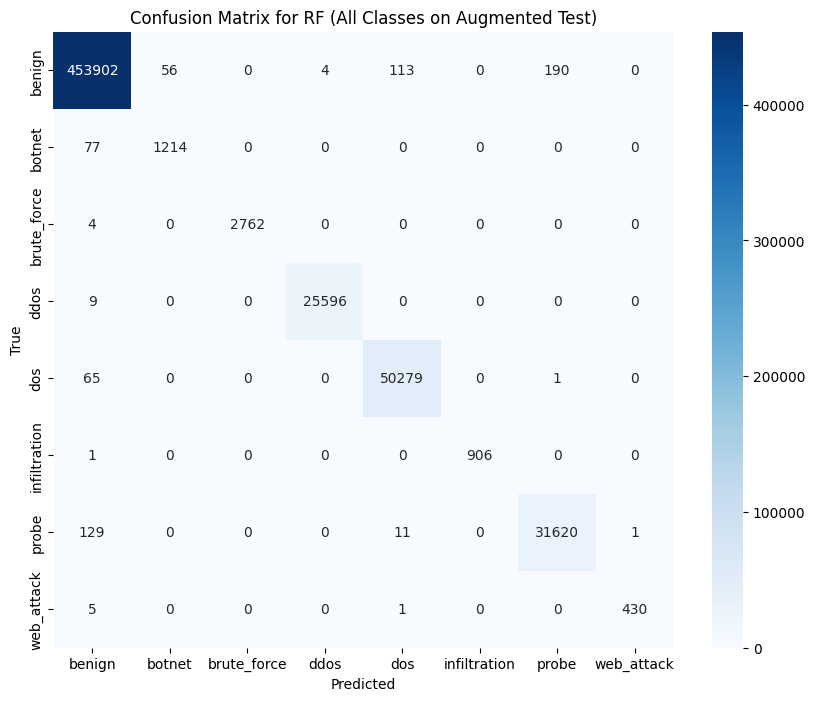

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=9000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 2.18 seconds
Vanilla GAN Epoch 5/50, Time: 0.02 seconds
Vanilla GAN Epoch 10/50, Time: 0.02 seconds
Vanilla GAN Epoch 15/50, Time: 0.02 seconds
Vanilla GAN Epoch 20/50, Time: 0.02 seconds
Vanilla GAN Epoch 25/50, Time: 0.02 seconds
Vanilla GAN Epoch 30/50, Time: 0.02 seconds
Vanilla GAN Epoch 35/50, Time: 0.02 seconds
Vanilla GAN Epoch 40/50, Time: 0.02 seconds
Vanilla GAN Epoch 45/50, Time: 0.02 seconds
Training VanillaGAN took 3.02 seconds
Generated samples shape: (2500, 32)
WGAN-GP Epoch 0/50, Time: 1.81 seconds
WGAN-GP Epoch 5/50, Time: 0.02 seconds
WGAN-GP Epoch 10/50, Time: 0.02 seconds
WGAN-GP Epoch 15/50, Time: 0.02 seconds
WGAN-GP Epoch 20/50, Time: 0.02 seconds
WGAN-GP Epoch 25/50, Time: 0.02 seconds
WGAN-GP Epoch 30/50, Time: 0.02 seconds
WGAN-GP Epoch 35/50, Time: 0.02 seconds
WGAN-GP Epoch 40/50, Time: 0.02 seconds
WGAN-GP Epoch 45/50, Time: 0.02 seconds
Training WGANGP took 2.69 seconds
Generated samples shape: (2500, 32)
Conditional GAN Epoc

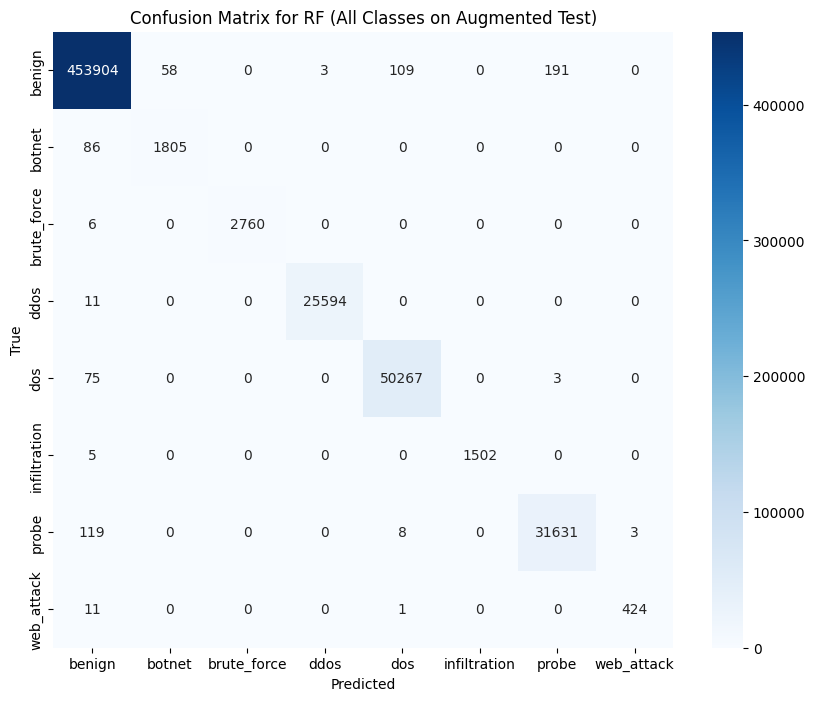

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=15000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 1.79 seconds
Vanilla GAN Epoch 5/50, Time: 0.02 seconds
Vanilla GAN Epoch 10/50, Time: 0.02 seconds
Vanilla GAN Epoch 15/50, Time: 0.02 seconds
Vanilla GAN Epoch 20/50, Time: 0.02 seconds
Vanilla GAN Epoch 25/50, Time: 0.02 seconds
Vanilla GAN Epoch 30/50, Time: 0.02 seconds
Vanilla GAN Epoch 35/50, Time: 0.02 seconds
Vanilla GAN Epoch 40/50, Time: 0.02 seconds
Vanilla GAN Epoch 45/50, Time: 0.02 seconds
Training VanillaGAN took 2.67 seconds
Generated samples shape: (4000, 32)
WGAN-GP Epoch 0/50, Time: 1.80 seconds
WGAN-GP Epoch 5/50, Time: 0.02 seconds
WGAN-GP Epoch 10/50, Time: 0.02 seconds
WGAN-GP Epoch 15/50, Time: 0.02 seconds
WGAN-GP Epoch 20/50, Time: 0.02 seconds
WGAN-GP Epoch 25/50, Time: 0.02 seconds
WGAN-GP Epoch 30/50, Time: 0.02 seconds
WGAN-GP Epoch 35/50, Time: 0.02 seconds
WGAN-GP Epoch 40/50, Time: 0.02 seconds
WGAN-GP Epoch 45/50, Time: 0.02 seconds
Training WGANGP took 2.64 seconds
Generated samples shape: (4000, 32)
Conditional GAN Epoc

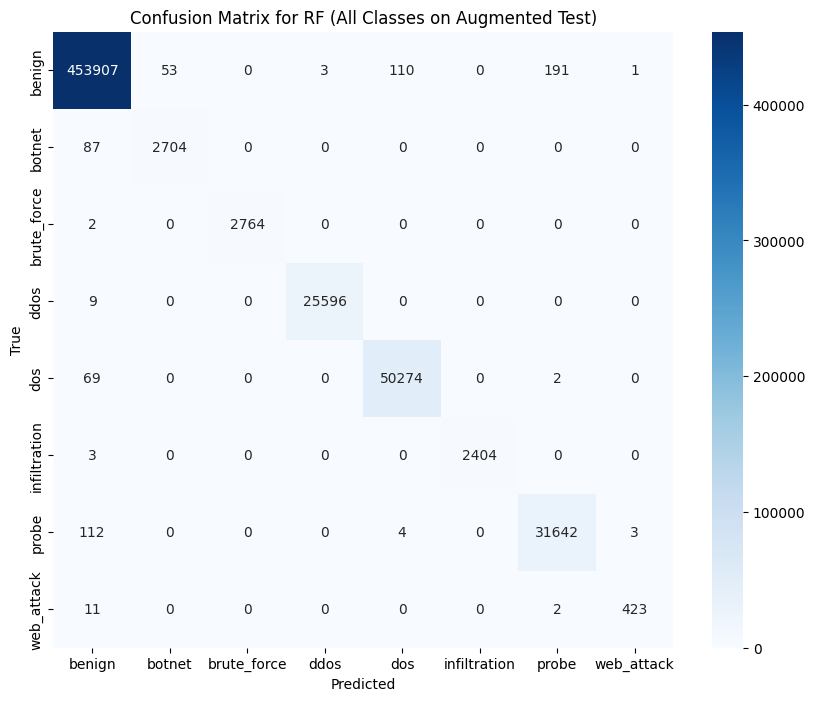

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=24000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 1.87 seconds
Vanilla GAN Epoch 5/50, Time: 0.02 seconds
Vanilla GAN Epoch 10/50, Time: 0.02 seconds
Vanilla GAN Epoch 15/50, Time: 0.02 seconds
Vanilla GAN Epoch 20/50, Time: 0.02 seconds
Vanilla GAN Epoch 25/50, Time: 0.02 seconds
Vanilla GAN Epoch 30/50, Time: 0.02 seconds
Vanilla GAN Epoch 35/50, Time: 0.02 seconds
Vanilla GAN Epoch 40/50, Time: 0.02 seconds
Vanilla GAN Epoch 45/50, Time: 0.02 seconds
Training VanillaGAN took 2.72 seconds
Generated samples shape: (5500, 32)
WGAN-GP Epoch 0/50, Time: 1.80 seconds
WGAN-GP Epoch 5/50, Time: 0.02 seconds
WGAN-GP Epoch 10/50, Time: 0.02 seconds
WGAN-GP Epoch 15/50, Time: 0.02 seconds
WGAN-GP Epoch 20/50, Time: 0.02 seconds
WGAN-GP Epoch 25/50, Time: 0.02 seconds
WGAN-GP Epoch 30/50, Time: 0.02 seconds
WGAN-GP Epoch 35/50, Time: 0.02 seconds
WGAN-GP Epoch 40/50, Time: 0.02 seconds
WGAN-GP Epoch 45/50, Time: 0.02 seconds
Training WGANGP took 2.67 seconds
Generated samples shape: (5500, 32)
Conditional GAN Epoc

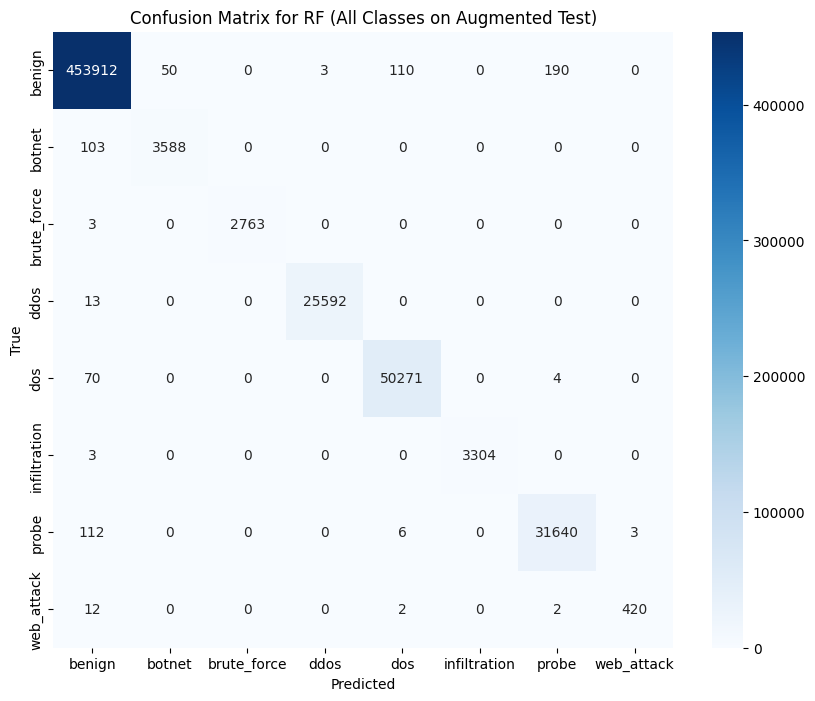

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=33000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 10.27 seconds
Vanilla GAN Epoch 5/50, Time: 0.27 seconds
Vanilla GAN Epoch 10/50, Time: 0.15 seconds
Vanilla GAN Epoch 15/50, Time: 0.19 seconds
Vanilla GAN Epoch 20/50, Time: 0.18 seconds
Vanilla GAN Epoch 25/50, Time: 0.31 seconds
Vanilla GAN Epoch 30/50, Time: 0.15 seconds
Vanilla GAN Epoch 35/50, Time: 0.13 seconds
Vanilla GAN Epoch 40/50, Time: 0.13 seconds
Vanilla GAN Epoch 45/50, Time: 0.28 seconds
Training VanillaGAN took 20.76 seconds
Generated samples shape: (10000, 32)
WGAN-GP Epoch 0/50, Time: 6.12 seconds
WGAN-GP Epoch 5/50, Time: 0.27 seconds
WGAN-GP Epoch 10/50, Time: 0.28 seconds
WGAN-GP Epoch 15/50, Time: 0.32 seconds
WGAN-GP Epoch 20/50, Time: 0.22 seconds
WGAN-GP Epoch 25/50, Time: 0.29 seconds
WGAN-GP Epoch 30/50, Time: 0.12 seconds
WGAN-GP Epoch 35/50, Time: 0.12 seconds
WGAN-GP Epoch 40/50, Time: 0.14 seconds
WGAN-GP Epoch 45/50, Time: 0.19 seconds
Training WGANGP took 16.52 seconds
Generated samples shape: (10000, 32)
Conditional GAN

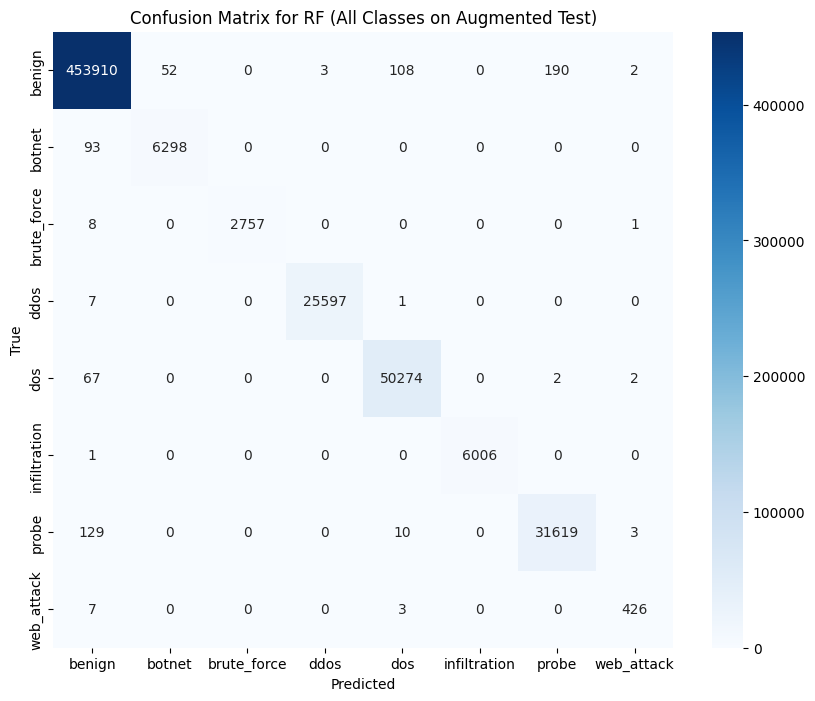

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=60000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 2.52 seconds
Vanilla GAN Epoch 5/50, Time: 0.05 seconds
Vanilla GAN Epoch 10/50, Time: 0.05 seconds
Vanilla GAN Epoch 15/50, Time: 0.05 seconds
Vanilla GAN Epoch 20/50, Time: 0.06 seconds
Vanilla GAN Epoch 25/50, Time: 0.06 seconds
Vanilla GAN Epoch 30/50, Time: 0.06 seconds
Vanilla GAN Epoch 35/50, Time: 0.05 seconds
Vanilla GAN Epoch 40/50, Time: 0.08 seconds
Vanilla GAN Epoch 45/50, Time: 0.05 seconds
Training VanillaGAN took 5.46 seconds
Generated samples shape: (11000, 32)
WGAN-GP Epoch 0/50, Time: 2.71 seconds
WGAN-GP Epoch 5/50, Time: 0.07 seconds
WGAN-GP Epoch 10/50, Time: 0.14 seconds
WGAN-GP Epoch 15/50, Time: 0.14 seconds
WGAN-GP Epoch 20/50, Time: 0.14 seconds
WGAN-GP Epoch 25/50, Time: 0.14 seconds
WGAN-GP Epoch 30/50, Time: 0.13 seconds
WGAN-GP Epoch 35/50, Time: 0.14 seconds
WGAN-GP Epoch 40/50, Time: 0.14 seconds
WGAN-GP Epoch 45/50, Time: 0.15 seconds
Training WGANGP took 9.10 seconds
Generated samples shape: (11000, 32)
Conditional GAN Ep

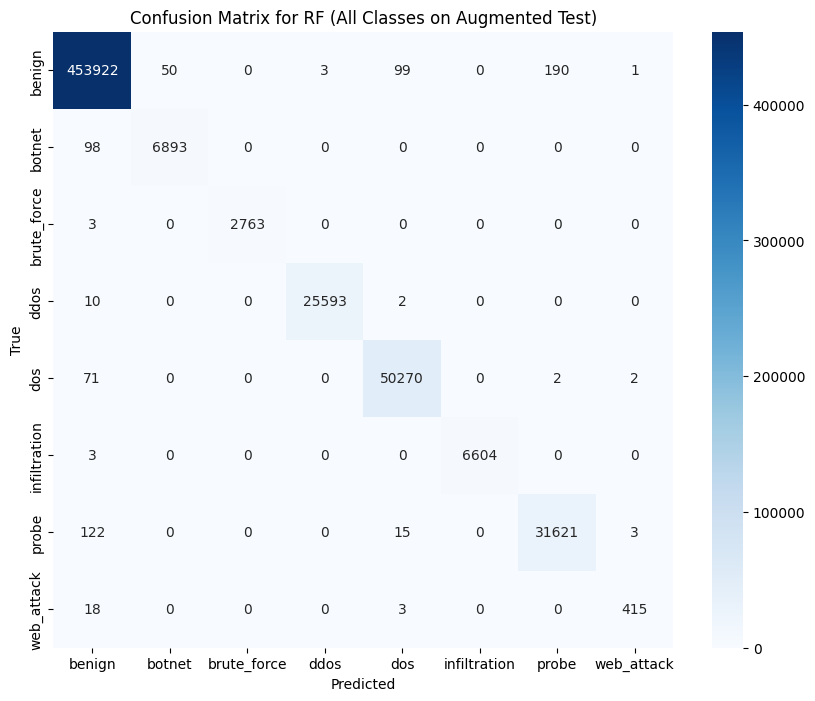

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=66000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 5.31 seconds
Vanilla GAN Epoch 5/50, Time: 0.07 seconds
Vanilla GAN Epoch 10/50, Time: 0.08 seconds
Vanilla GAN Epoch 15/50, Time: 0.09 seconds
Vanilla GAN Epoch 20/50, Time: 0.07 seconds
Vanilla GAN Epoch 25/50, Time: 0.05 seconds
Vanilla GAN Epoch 30/50, Time: 0.07 seconds
Vanilla GAN Epoch 35/50, Time: 0.06 seconds
Vanilla GAN Epoch 40/50, Time: 0.07 seconds
Vanilla GAN Epoch 45/50, Time: 0.06 seconds
Training VanillaGAN took 9.82 seconds
Generated samples shape: (16500, 32)
WGAN-GP Epoch 0/50, Time: 5.17 seconds
WGAN-GP Epoch 5/50, Time: 0.08 seconds
WGAN-GP Epoch 10/50, Time: 0.08 seconds
WGAN-GP Epoch 15/50, Time: 0.07 seconds
WGAN-GP Epoch 20/50, Time: 0.07 seconds
WGAN-GP Epoch 25/50, Time: 0.07 seconds
WGAN-GP Epoch 30/50, Time: 0.09 seconds
WGAN-GP Epoch 35/50, Time: 0.12 seconds
WGAN-GP Epoch 40/50, Time: 0.14 seconds
WGAN-GP Epoch 45/50, Time: 0.12 seconds
Training WGANGP took 10.03 seconds
Generated samples shape: (16500, 32)
Conditional GAN E

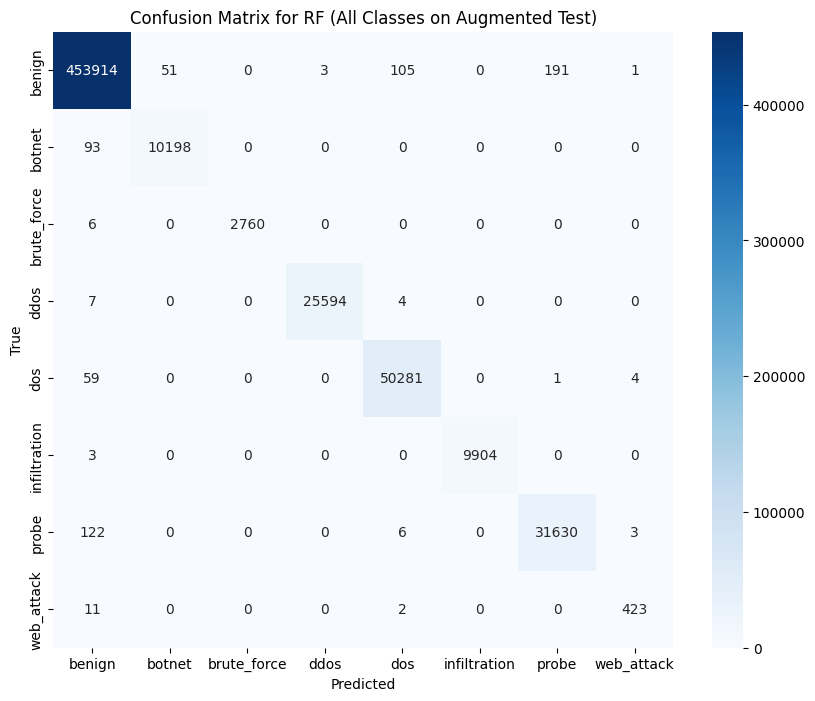

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=99000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

Vanilla GAN Epoch 0/50, Time: 7.49 seconds
Vanilla GAN Epoch 5/50, Time: 0.10 seconds
Vanilla GAN Epoch 10/50, Time: 0.10 seconds
Vanilla GAN Epoch 15/50, Time: 0.10 seconds
Vanilla GAN Epoch 20/50, Time: 0.05 seconds
Vanilla GAN Epoch 25/50, Time: 0.05 seconds
Vanilla GAN Epoch 30/50, Time: 0.05 seconds
Vanilla GAN Epoch 35/50, Time: 0.06 seconds
Vanilla GAN Epoch 40/50, Time: 0.05 seconds
Vanilla GAN Epoch 45/50, Time: 0.05 seconds
Training VanillaGAN took 12.01 seconds
Generated samples shape: (21000, 32)
WGAN-GP Epoch 0/50, Time: 3.45 seconds
WGAN-GP Epoch 5/50, Time: 0.12 seconds
WGAN-GP Epoch 10/50, Time: 0.12 seconds
WGAN-GP Epoch 15/50, Time: 0.10 seconds
WGAN-GP Epoch 20/50, Time: 0.09 seconds
WGAN-GP Epoch 25/50, Time: 0.09 seconds
WGAN-GP Epoch 30/50, Time: 0.12 seconds
WGAN-GP Epoch 35/50, Time: 0.09 seconds
WGAN-GP Epoch 40/50, Time: 0.10 seconds
WGAN-GP Epoch 45/50, Time: 0.10 seconds
Training WGANGP took 8.60 seconds
Generated samples shape: (21000, 32)
Conditional GAN E

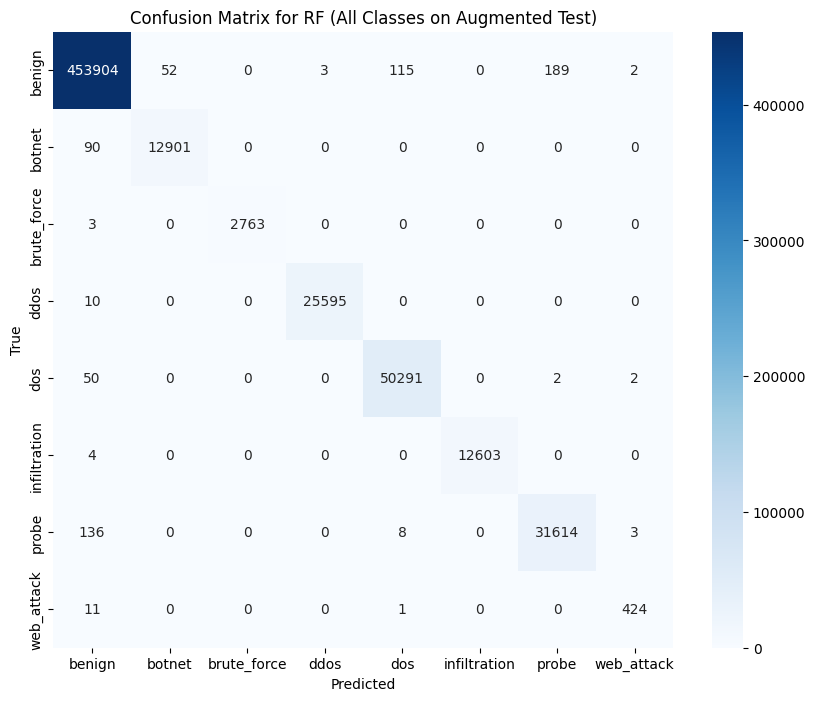

In [ ]:
#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=126000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classi#same approach increased n_samples to 3000
import torch
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

class WGANGP:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class VanillaGAN:
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(generated_data, training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Vanilla GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

class ConditionalGAN:
    def __init__(self, latent_dim=100, n_classes=1, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.n_classes = n_classes  # Single class for training
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None

    def build_generator(self, input_dim):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([noise_input, label_input])
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(input_dim, activation='tanh')(x)
        return models.Model([noise_input, label_input], x)

    def build_discriminator(self, input_dim):
        data_input = layers.Input(shape=(input_dim,))
        label_input = layers.Input(shape=(self.n_classes,))
        x = layers.Concatenate()([data_input, label_input])
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        return models.Model([data_input, label_input], x)

    def train(self, X_train, y_train):
        X_train = X_train.astype(np.float32)
        y_train_onehot = tf.keras.utils.to_categorical(y_train, self.n_classes)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        @tf.function
        def train_step(real_data, real_labels):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator([noise, real_labels], training=True)
                real_output = self.discriminator([real_data, real_labels], training=True)
                fake_output = self.discriminator([fake_data, real_labels], training=True)

                gen_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
                )
                disc_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) +
                    tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                )

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot)).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data, real_labels in dataset:
                train_step(real_data, real_labels)
            end = time.time()
            if epoch % 5 == 0:
                print(f"Conditional GAN Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples, labels):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        labels_onehot = tf.keras.utils.to_categorical(labels, self.n_classes)
        labels_onehot = tf.convert_to_tensor(labels_onehot, dtype=tf.float32)
        return self.generator([noise, labels_onehot]).numpy()

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []  # Numerical features only
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)  # Fixed equal weights
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)  # Single class (0)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=1000):
        # Split data into botnet and infiltration
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        # Split n_samples equally between botnet and infiltration
        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2  # Extra samples go to botnet
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        # Initialize lists for samples and labels
        final_samples = []
        final_labels = []

        # Generate botnet samples
        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                # Train GAN on botnet data
                self.train_gan(gan, X_botnet)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        # Generate infiltration samples
        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                # Train GAN on infiltration data
                self.train_gan(gan, X_infiltration)
                # Generate samples
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        # Combine samples and labels
        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels


# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=99000)  # Adjust n_samples as needed

# Add synthetic to full dataset
X_augmented = np.vstack((xs_selected, final_samples))
y_augmented = np.hstack((y_encoded, final_labels))

# Now, perform train-test split on augmented data
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=0, stratify=y_augmented)

# Train RF
classifier = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')  # Add class_weight for imbalance
start = time.time()
classifier.fit(X_train, y_train)
end = time.time()
training_time = end - start
print(f"RF Training Time: {training_time:.2f} seconds")

# Test
start = time.time()
y_test_predicted = classifier.predict(X_test)
end = time.time()
testing_time = end - start
print(f"Testing Time: {testing_time:.2f} seconds")

# Classification report
print("\nRF Classification Report (All Classes on Augmented Test):")
print(classification_report(y_test, y_test_predicted, target_names=le.classes_, zero_division=0))

# Confusion matrix
confusion_rf = confusion_matrix(y_test, y_test_predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF (All Classes on Augmented Test)')
plt.show()

# # Feature importance visualization (optional, on classifier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()fier)
# feature_importances = classifier.feature_importances_
# sorted_importances = sorted(feature_importances, reverse=True)
# sorted_features = selected_features[np.argsort(feature_importances)[::-1]]

# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_importances)), sorted_importances, color='#00008B')
# plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90, fontsize=8)
# plt.title('Feature Importance Scores from RF')
# plt.xlabel('Features')
# plt.ylabel('Score')
# plt.tight_layout()
# plt.savefig('features.png', dpi=400)
# plt.show()

#Quality Check for synthetic samples vs original

Top 8 most representing features based on RF importance:
- Destination_Port (importance: 0.1051)
- Avg_Bwd_Segment_Size (importance: 0.0571)
- Init_Win_bytes_forward (importance: 0.0570)
- Average_Packet_Size (importance: 0.0534)
- Fwd_IAT_Total (importance: 0.0461)
- PSH_Flag_Count (importance: 0.0460)
- SYN_Flag_Count (importance: 0.0440)
- Packet_Length_Mean (importance: 0.0432)


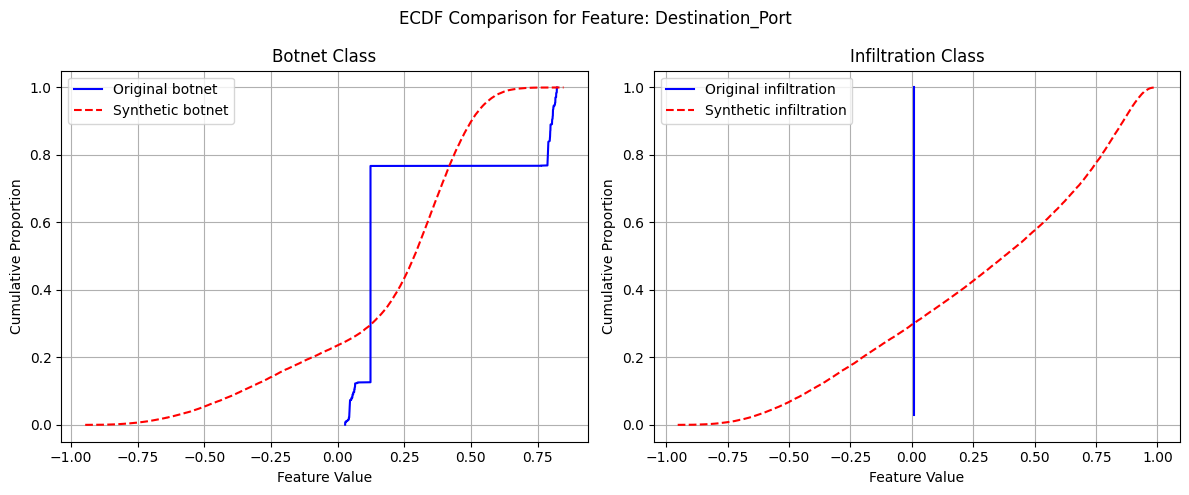

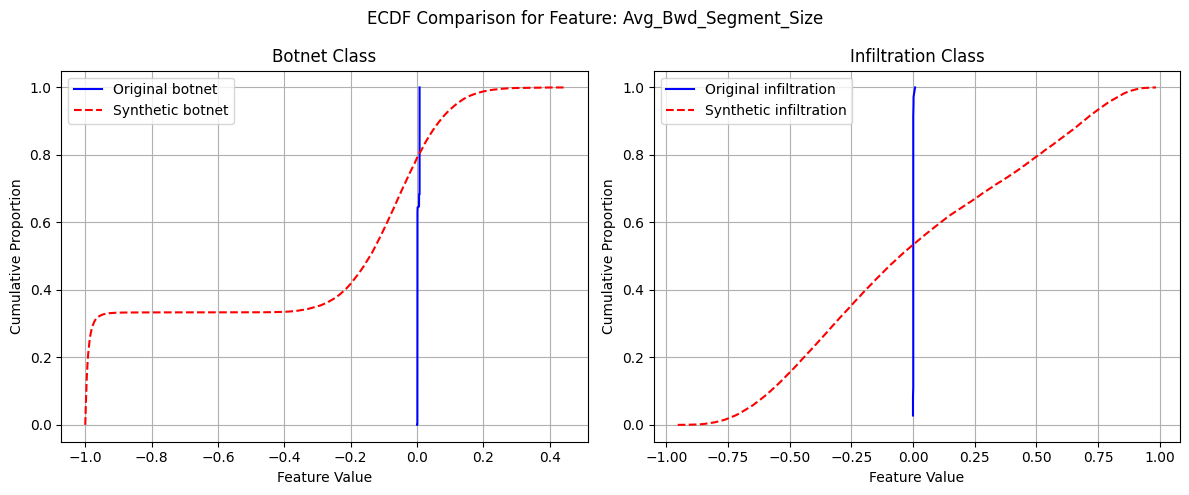

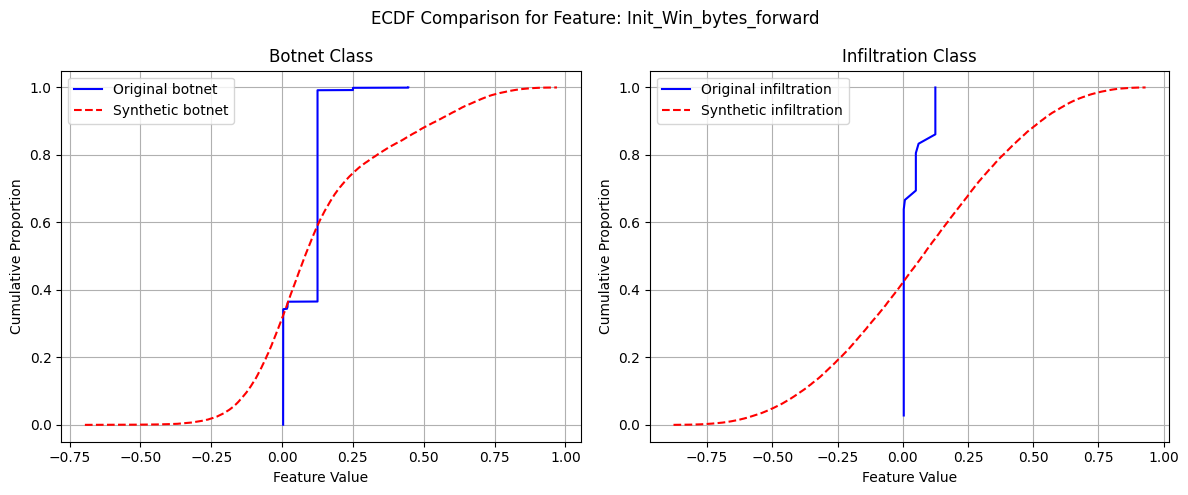

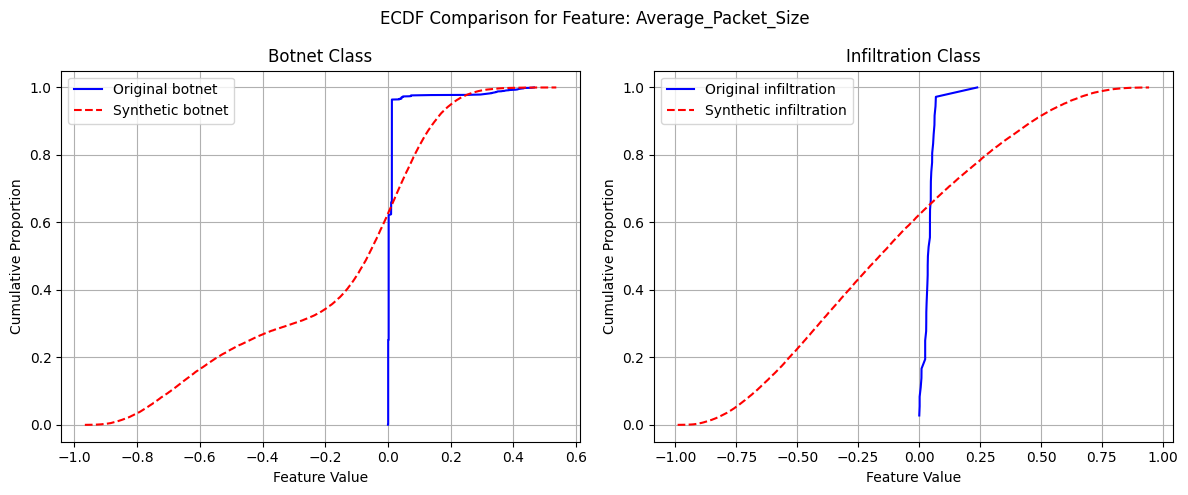

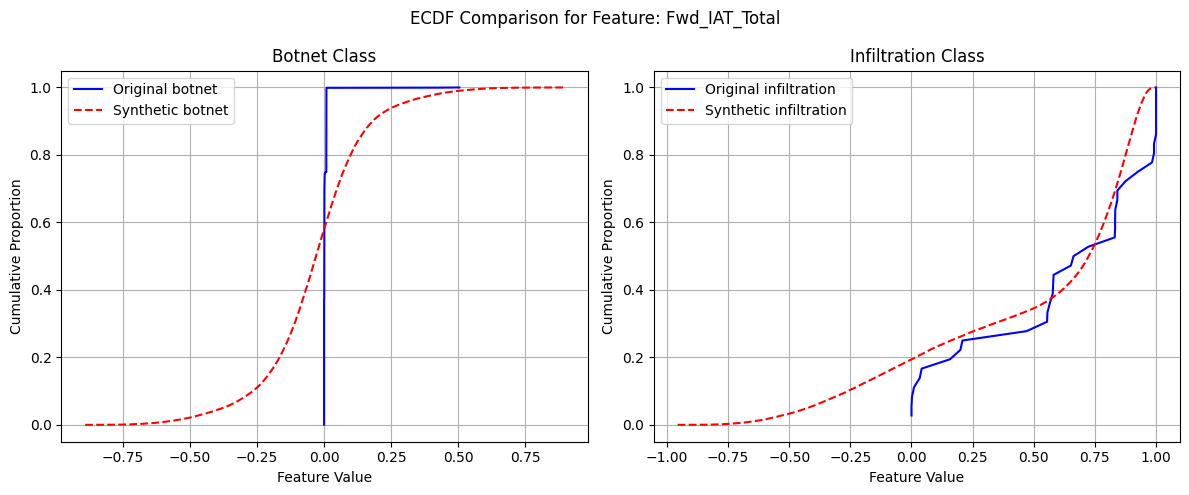

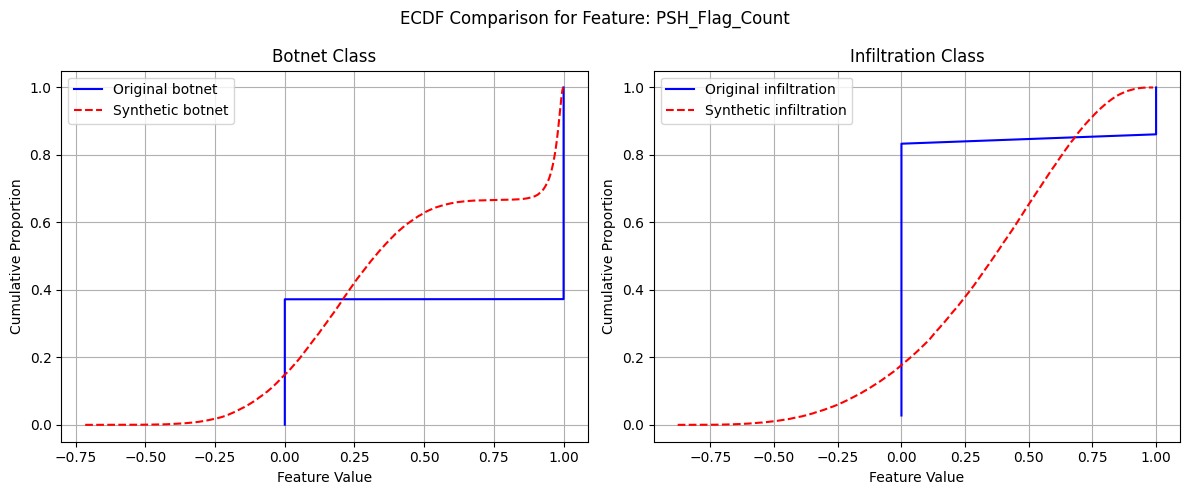

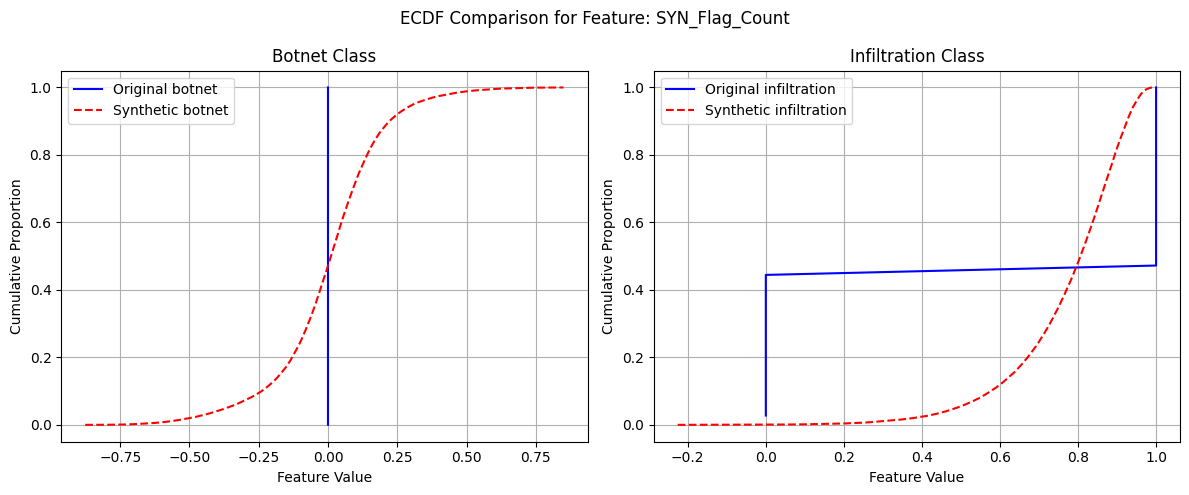

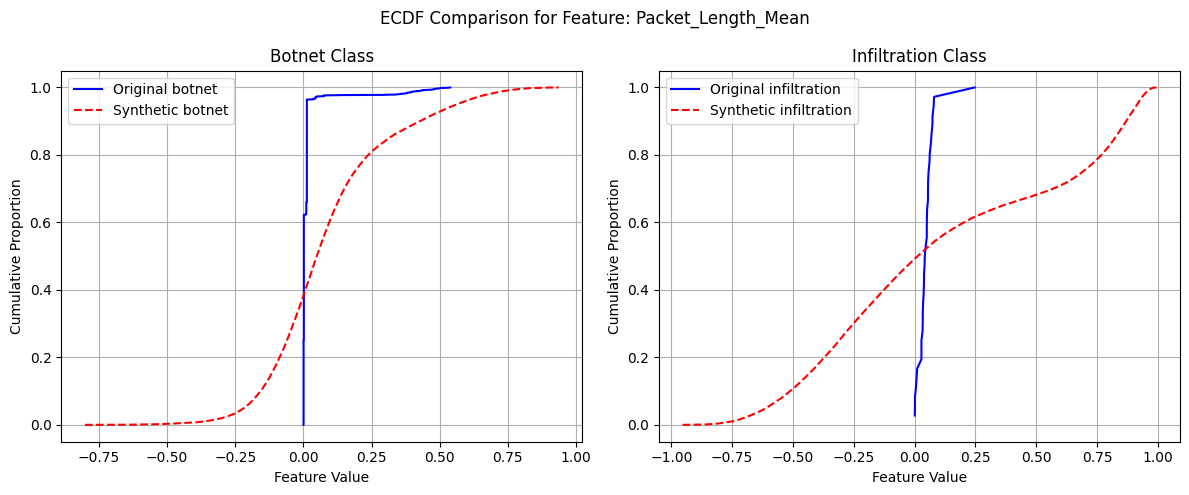

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
# - le: LabelEncoder instance
# - ensemble.botnet_label: encoded label for 'botnet'
# - ensemble.infiltration_label: encoded label for 'infiltration'

# Step 1: Get feature importances from the trained RF classifier
feature_importances = classifier.feature_importances_

# Step 2: Identify the top 8 most important features
top_indices = np.argsort(feature_importances)[::-1][:8]
top_features = [selected_features[i] for i in top_indices]

print("Top 8 most representing features based on RF importance:")
for idx, feat in zip(top_indices, top_features):
    print(f"- {feat} (importance: {feature_importances[idx]:.4f})")

# Step 3: Define a function to plot Empirical Cumulative Distribution Function (ECDF)
def plot_ecdf(ax, data, label, color, linestyle='-'):
    if len(data) == 0:
        print(f"No data for {label}")
        return
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, y, label=label, color=color, linestyle=linestyle)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Cumulative Proportion')
    ax.legend()
    ax.grid(True)

# Step 4: Plot ECDF comparisons for each of the top 8 features, per vulnerable class
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in zip(top_indices, top_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'ECDF Comparison for Feature: {feat_name}')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Extract data for synthetic
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot ECDFs
        ax = axs[ax_idx]
        plot_ecdf(ax, orig_data, f'Original {class_name}', 'blue')
        plot_ecdf(ax, synth_data, f'Synthetic {class_name}', 'red', linestyle='--')
        ax.set_title(f'{class_name.capitalize()} Class')

    plt.tight_layout()
    plt.show()

Feature Total_Length_of_Fwd_Packets not found in selected_features
Feature Flow_Packets_s not found in selected_features
Feature Bwd_IAT_Mean not found in selected_features
Feature Init_Win_bytes_backward not found in selected_features
Selected features for ECDF analysis:
- Flow_Duration
- Total_Length_of_Fwd_Packets
- Flow_Packets_s
- Flow_IAT_Mean


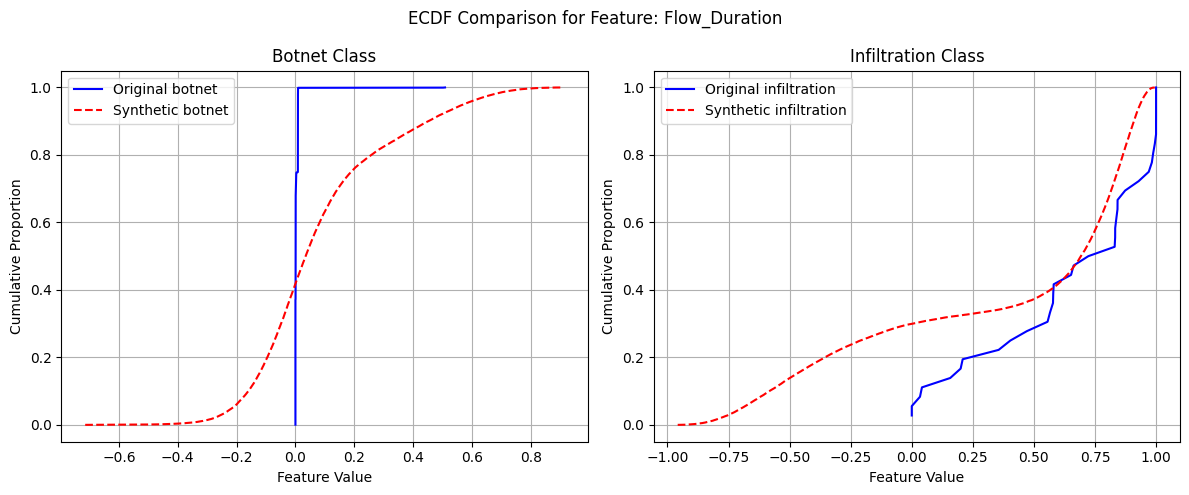

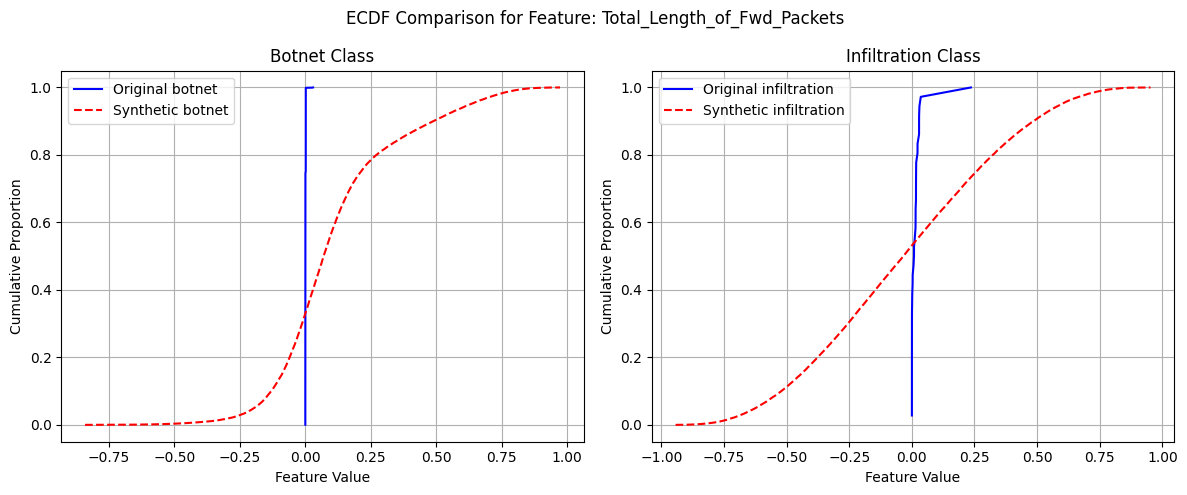

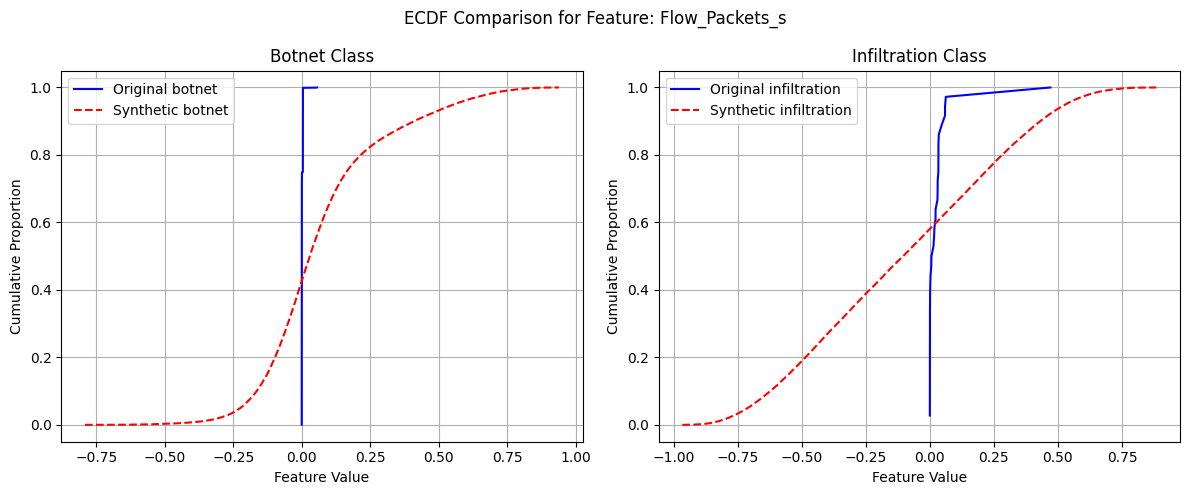

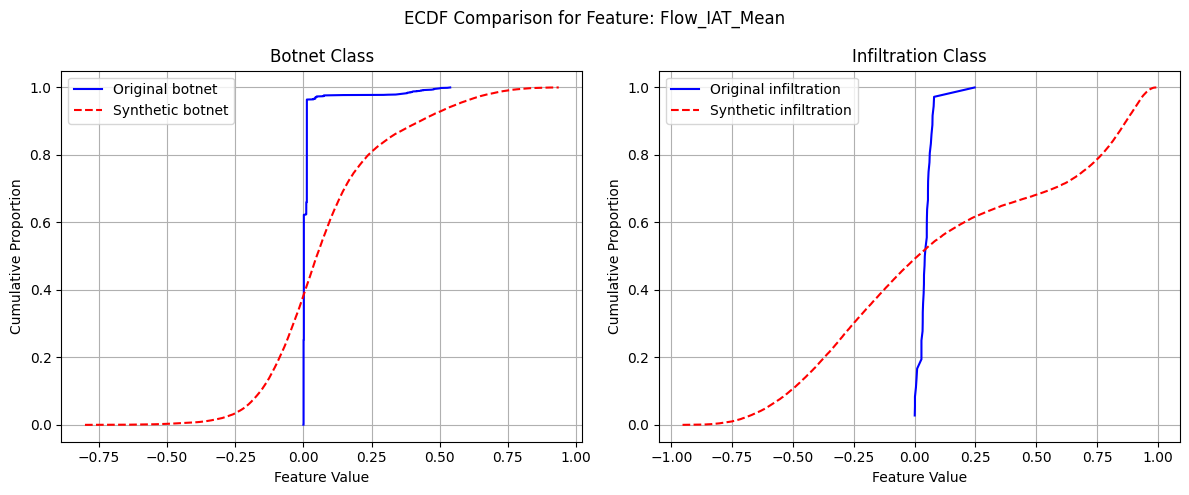

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
# - le: LabelEncoder instance
# - ensemble.botnet_label: encoded label for 'botnet'
# - ensemble.infiltration_label: encoded label for 'infiltration'

# Step 1: Define the specified features
specified_features = [
    'Flow_Duration',
    'Total_Length_of_Fwd_Packets',
    'Flow_Packets_s',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_backward'
]

# Step 2: Find indices of specified features in selected_features
top_features = specified_features
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
    except ValueError:
        print(f"Feature {feat} not found in selected_features")
        continue

# Step 3: Print the selected features (for verification)
print("Selected features for ECDF analysis:")
for idx, feat in zip(top_indices, top_features):
    print(f"- {feat}")

# Step 4: Define a function to plot Empirical Cumulative Distribution Function (ECDF)
def plot_ecdf(ax, data, label, color, linestyle='-'):
    if len(data) == 0:
        print(f"No data for {label}")
        return
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.plot(sorted_data, y, label=label, color=color, linestyle=linestyle)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Cumulative Proportion')
    ax.legend()
    ax.grid(True)

# Step 5: Plot ECDF comparisons for each of the specified features, per vulnerable class
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in zip(top_indices, top_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'ECDF Comparison for Feature: {feat_name}')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Extract data for syntheticimport matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
…    plt.tight_layout()
    plt.show()
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot ECDFs
        ax = axs[ax_idx]
        plot_ecdf(ax, orig_data, f'Original {class_name}', 'blue')import torch
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Assuming x_vuln_all, y_vuln_all, xs, xs_selected, y_encoded, and le are defined earlier
# xs is the original DataFrame with full feature names

class WGANGP:
    # [Same as your WGANGP class, unchanged]
    def __init__(self, latent_dim=100, epochs=20, batch_size=512):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.generator = None
        self.discriminator = None
        self.gp_weight = 10.0

    def build_generator(self, input_dim):
        model = models.Sequential([
            layers.Dense(128, input_dim=self.latent_dim, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim, activation='tanh')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = models.Sequential([
            layers.Dense(256, input_dim=input_dim, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(1)
        ])
        return model

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0, dtype=tf.float32)
        interpolated = alpha * tf.cast(real_samples, tf.float32) + (1 - alpha) * tf.cast(fake_samples, tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = tape.gradient(pred, interpolated)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train(self, X_train):
        X_train = X_train.astype(np.float32)
        input_dim = X_train.shape[1]
        self.generator = self.build_generator(input_dim)
        self.discriminator = self.build_discriminator(input_dim)

        gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

        @tf.function
        def train_step(real_data):
            batch_size = tf.shape(real_data)[0]
            noise = tf.random.normal([batch_size, self.latent_dim], dtype=tf.float32)

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self.gradient_penalty(real_data, fake_data)
                disc_loss += self.gp_weight * gp

                gen_loss = -tf.reduce_mean(fake_output)

            gen_grads = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            disc_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))

        dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000).batch(self.batch_size)
        for epoch in range(self.epochs):
            start = time.time()
            for real_data in dataset:
                train_step(real_data)
            end = time.time()
            if epoch % 5 == 0:
                print(f"WGAN-GP Epoch {epoch}/{self.epochs}, Time: {end - start:.2f} seconds")

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.latent_dim], dtype=tf.float32)
        return self.generator(noise).numpy()

# [VanillaGAN and ConditionalGAN classes remain the same as in your code]

class DynamicGANEnsemble:
    def __init__(self, latent_dim=100, epochs=50, batch_size=512, le=None):
        self.discrete_columns = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gans = [
            VanillaGAN(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            WGANGP(latent_dim=latent_dim, epochs=epochs, batch_size=batch_size),
            ConditionalGAN(latent_dim=latent_dim, n_classes=1, epochs=epochs, batch_size=batch_size)
        ]
        self.weights = [1.0 / len(self.gans)] * len(self.gans)
        self.le = le
        if le is not None:
            self.infiltration_label = le.transform(['infiltration'])[0]
            self.botnet_label = le.transform(['botnet'])[0]
        else:
            raise ValueError("LabelEncoder (le) must be provided")

    def train_gan(self, gan, X_train, y_train=None):
        try:
            start = time.time()
            if isinstance(gan, (VanillaGAN, WGANGP)):
                gan.train(X_train)
            elif isinstance(gan, ConditionalGAN):
                X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train
                X_train = X_train.astype(np.float32)
                y_train = np.zeros(len(X_train), dtype=np.int32)
                gan.train(X_train.values, y_train)
            else:
                raise ValueError("Unknown GAN type")
            end = time.time()
            print(f"Training {type(gan).__name__} took {end - start:.2f} seconds")
            return gan
        except Exception as e:
            print(f"Error training GAN {type(gan).__name__}: {str(e)}")
            return None

    def generate_samples(self, gan, n_samples, labels=None):
        try:
            if isinstance(gan, ConditionalGAN):
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples, np.zeros(n_samples, dtype=np.int32))
            else:
                if gan is None:
                    return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)
                samples = gan.sample(n_samples)
            samples = np.array(samples, dtype=np.float32)
            print(f"Generated samples shape: {samples.shape}")
            return samples
        except Exception as e:
            print(f"Error generating samples from {type(gan).__name__}: {str(e)}")
            return np.zeros((n_samples, x_vuln_all.shape[1]), dtype=np.float32)

    def generate(self, X_vuln_all, y_vuln_all, n_samples=99000):
        botnet_indices = y_vuln_all == self.botnet_label
        infiltration_indices = y_vuln_all == self.infiltration_label
        X_botnet = X_vuln_all[botnet_indices]
        X_infiltration = X_vuln_all[infiltration_indices]

        n_samples_per_class = n_samples // 2
        remainder = n_samples % 2
        n_botnet = n_samples_per_class + remainder
        n_infiltration = n_samples_per_class

        final_samples = []
        final_labels = []

        n_samples_per_gan = n_botnet // len(self.gans)
        botnet_remainder = n_botnet % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < botnet_remainder else 0)
            if current_samples > 0:
                self.train_gan(gan, X_botnet)
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.botnet_label))

        n_samples_per_gan = n_infiltration // len(self.gans)
        infiltration_remainder = n_infiltration % len(self.gans)
        for i, gan in enumerate(self.gans):
            current_samples = n_samples_per_gan + (1 if i < infiltration_remainder else 0)
            if current_samples > 0:
                self.train_gan(gan, X_infiltration)
                samples = self.generate_samples(gan, current_samples)
                final_samples.append(samples)
                final_labels.append(np.full(current_samples, self.infiltration_label))

        final_samples = np.vstack(final_samples)
        final_labels = np.hstack(final_labels)
        print(f"Total generated samples: {final_samples.shape[0]}")
        return final_samples, final_labels

# Generate synthetic data
ensemble = DynamicGANEnsemble(latent_dim=100, epochs=50, batch_size=512, le=le)
final_samples, final_labels = ensemble.generate(x_vuln_all, y_vuln_all, n_samples=99000)

# Use xs.columns for full feature names
feature_names = xs.columns.tolist()  # Assuming xs is a DataFrame with all original features

# Define specified features and find their indices in the full set
specified_features = [
    'Flow_Duration', 'Total_Length_of_Fwd_Packets', 'Flow_Packets_s', 'Flow_IAT_Mean',
    'Fwd_IAT_Mean', 'Bwd_IAT_Mean', 'Packet_Length_Mean', 'Init_Win_bytes_backward'
]
feature_indices = []
for feat in specified_features:
    try:
        idx = feature_names.index(feat)
        feature_indices.append(idx)
    except ValueError:
        print(f"Feature {feat} not found in xs.columns")
        feature_indices.append(-1)  # Placeholder for missing features
print("Verified feature indices:", feature_indices)

# Filter out invalid indices and corresponding features
valid_indices = [i for i in feature_indices if i != -1]
valid_features = [feat for feat, idx in zip(specified_features, feature_indices) if idx != -1]
if len(valid_indices) < len(specified_features):
    print(f"Warning: Only {len(valid_indices)} out of {len(specified_features)} features found in xs.columns")

# Function to plot cumulative sums with specified axes
def plot_cumulative_sums(ax, orig_data, synth_data, label, y_range, color_orig='blue', color_synth='orange'):
    if len(orig_data) == 0 or len(synth_data) == 0:
        print(f"No data for {label}")
        return

    # Truncate synth_data to match orig_data length
    min_len = min(len(orig_data), len(synth_data))
    orig_data = orig_data[:min_len]
    synth_data = synth_data[:min_len]

    # Sort data
    orig_sorted = np.sort(orig_data)
    synth_sorted = np.sort(synth_data)

    # Compute cumulative sums
    orig_cumsum = np.cumsum(orig_sorted)
    synth_cumsum = np.cumsum(synth_sorted)

    # Fix X-axis to [0, 100, 200, 400, 500, 600] with equal spacing
    x_indices = [0, 100, 200, 400, 500, 600]
    t = np.linspace(0, min_len - 1, 6)
    orig_cumsum_sampled = np.interp(t, np.arange(min_len), orig_cumsum)
    synth_cumsum_sampled = np.interp(t, np.arange(min_len), synth_cumsum)

    # Scale Y-axis to match the specified range
    y_min, y_max = y_range[0], y_range[-1]
    scale_factor = (y_max - y_min) / np.max(orig_cumsum) if np.max(orig_cumsum) > 0 else 1
    orig_cumsum_scaled = (orig_cumsum_sampled * scale_factor) + y_min
    synth_cumsum_scaled = (synth_cumsum_sampled * scale_factor) + y_min

    # Plot with fixed axes
    ax.plot(x_indices, orig_cumsum_scaled, label=f'Original {label}', color=color_orig, linewidth=2)
    ax.plot(x_indices, synth_cumsum_scaled, label=f'Synthetic {label}', color=color_synth, linestyle='--', linewidth=2)
    ax.set_xlabel('Sorted Sample Index')
    ax.set_ylabel('Cumulative Sum')
    ax.set_title(f'Cumulative Sums for {label}')
    ax.set_xticks(x_indices)
    ax.set_yticks(y_range)
    ax.set_xlim(0, 600)
    ax.set_ylim(y_min, y_max)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=10)

# Define Y-axis ranges based on your input
y_ranges = {
    'Flow_Duration': [0, 1, 2, 3, 4, 5],
    'Total_Length_of_Fwd_Packets': [0, 20000, 40000, 60000, 100000, 120000, 140000, 160000],
    'Flow_Packets_s': [0, 10000, 20000, 30000, 40000, 50000, 60000],
    'Flow_IAT_Mean': [0, 2, 4, 6, 8],
    'Fwd_IAT_Mean': [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50],
    'Bwd_IAT_Mean': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
    'Packet_Length_Mean': [0, 5000, 10000, 15000, 20000, 25000, 30000],
    'Init_Win_bytes_backward': [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000]
}

# Plot cumulative sums for each valid feature
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in enumerate(valid_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
    fig.suptitle(f'Cumulative Sums for Feature: {feat_name}', fontsize=12, fontweight='bold')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, valid_indices[feat_idx]]  # Use valid index

        # Extract data for synthetic
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, valid_indices[feat_idx]]  # Use valid index

        # Plot Cumulative Sums
        ax = axs[ax_idx]
        plot_cumulative_sums(ax, orig_data, synth_data, class_name, y_ranges[feat_name])

    plt.tight_layout()
    plt.savefig(f'cumulative_sums_{feat_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

# Save the full synthetic dataset with all features
synthetic_df = pd.DataFrame(final_samples, columns=feature_names)
synthetic_df['label'] = final_labels
synthetic_df.to_csv('synthetic_data_full.csv', index=False)
print("Full synthetic dataset saved as 'synthetic_data_full.csv'")
        plot_ecdf(ax, synth_data, f'Synthetic {class_name}', 'red', linestyle='--')
        ax.set_title(f'{class_name.capitalize()} Class')

    plt.tight_layout()
    plt.show()

Found Flow_Duration at index 1
Found Flow_IAT_Mean at index 5
Found Fwd_IAT_Mean at index 9
Found Packet_Length_Mean at index 17
Error: Not all 8 features found. Adjust selected_features.


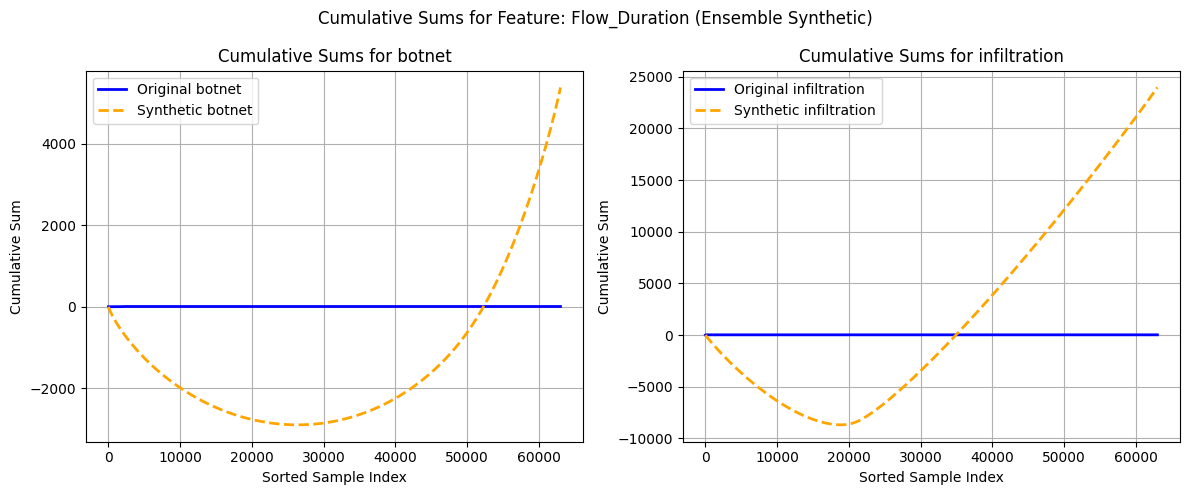

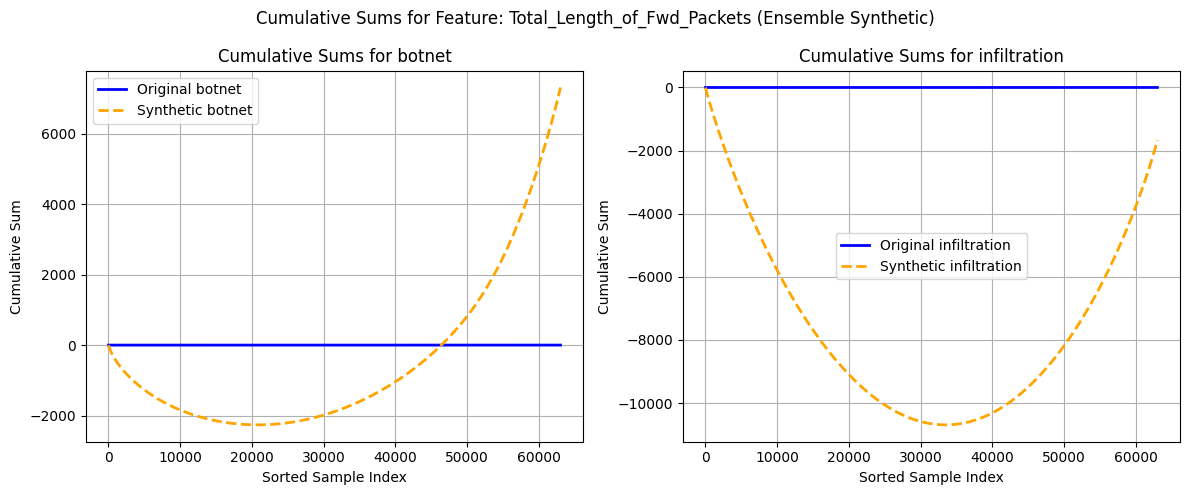

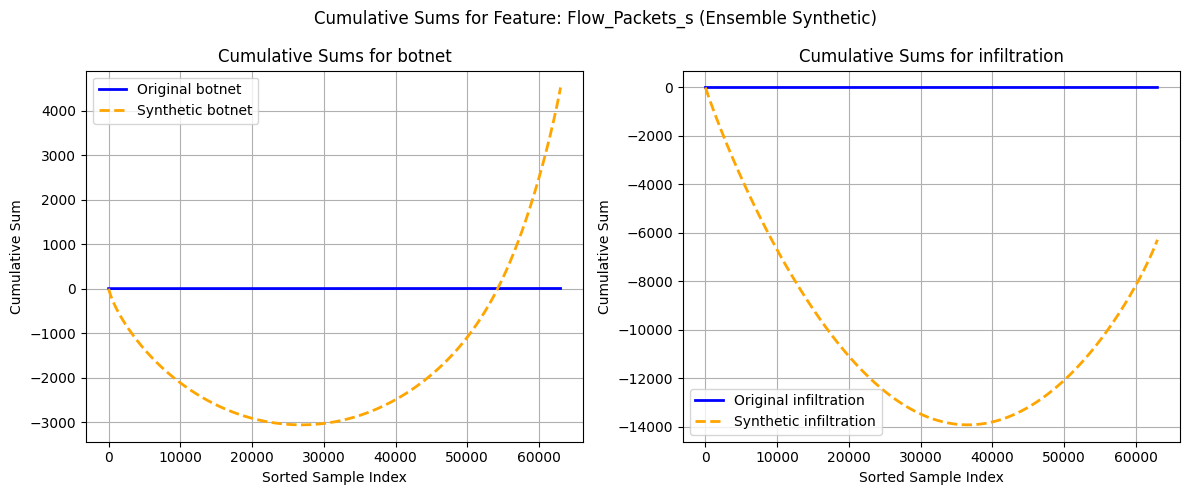

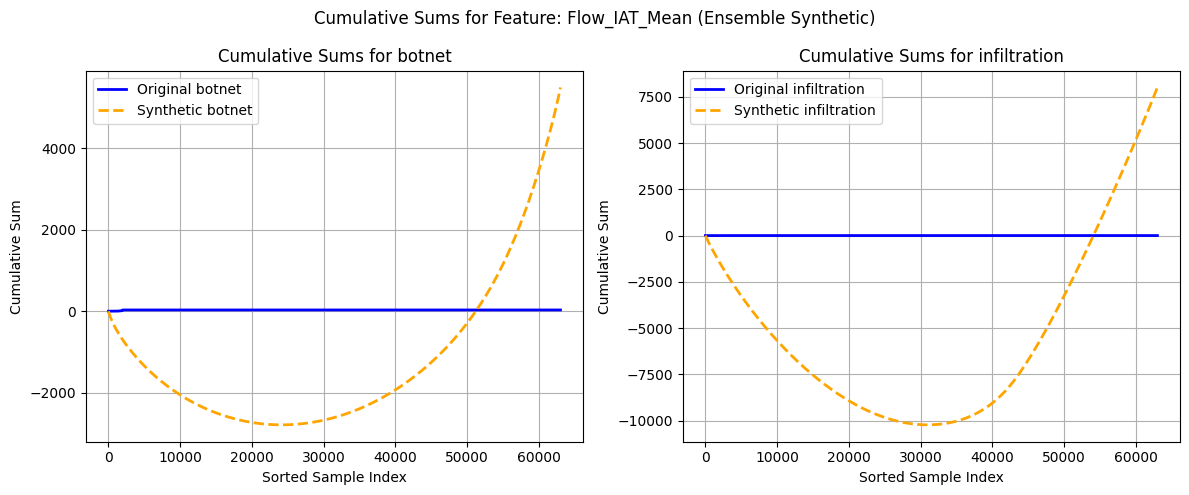


Cosine Similarities (Original vs. Synthetic per Feature/Class):
Flow_Duration (botnet): 1.0000
Flow_Duration (infiltration): 1.0000
Total_Length_of_Fwd_Packets (botnet): 1.0000
Total_Length_of_Fwd_Packets (infiltration): -1.0000
Flow_Packets_s (botnet): 1.0000
Flow_Packets_s (infiltration): -1.0000
Flow_IAT_Mean (botnet): 1.0000
Flow_IAT_Mean (infiltration): 1.0000

Overall Average Cosine Similarity: 0.5000

MSE Divergence on Cumulative Sum Curves (Lower = Better Match):
Flow_Duration (botnet): 5364049.7238
Flow_Duration (infiltration): 99688500.3848
Total_Length_of_Fwd_Packets (botnet): 5377187.4719
Total_Length_of_Fwd_Packets (infiltration): 65954015.9254
Flow_Packets_s (botnet): 5469477.9251
Flow_Packets_s (infiltration): 118047588.6599
Flow_IAT_Mean (botnet): 5098846.0720
Flow_IAT_Mean (infiltration): 52082075.9254

Overall Average MSE Divergence: 44635217.7610

KS-Test p-values (Higher = Better Similarity; >0.05 = No Significant Difference):
Flow_Duration (botnet): p=0.0000
Flow_

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp  # For additional KS-test (complements cumulative sums)

# Assuming variables from your script: x_vuln_all, y_vuln_all, final_samples, final_labels,
# le, ensemble.botnet_label, ensemble.infiltration_label, selected_features

# Step 1: Define the 8 specific features (as in the paper)
specified_features = [
    'Flow_Duration',
    'Total_Length_of_Fwd_Packets',
    'Flow_Packets_s',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_backward'
]

# Find indices (error if not found)
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
        print(f"Found {feat} at index {idx}")
    except ValueError:
        print(f"Warning: {feat} not in selected_features. Skipping.")
        continue

if len(top_indices) < len(specified_features):
    print("Error: Not all 8 features found. Adjust selected_features.")
    # Proceed with available ones, but ideally fix your feature selection

# Vulnerable classes
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

# Step 2: Function for Cumulative Sums Plot (as in paper: blue=original, orange=synthetic)
def plot_cumulative_sums(ax, orig_data, synth_data, label, color_orig='blue', color_synth='orange'):
    if len(orig_data) == 0 or len(synth_data) == 0:
        print(f"No data for {label}")
        return

    # Sort data
    orig_sorted = np.sort(orig_data)
    synth_sorted = np.sort(synth_data)

    # Compute cumulative sums
    orig_cumsum = np.cumsum(orig_sorted)
    synth_cumsum = np.cumsum(synth_sorted)

    # Create common x-axis for interpolation
    max_len = max(len(orig_cumsum), len(synth_cumsum))
    x_orig = np.arange(1, len(orig_cumsum) + 1)
    x_synth = np.arange(1, len(synth_cumsum) + 1)
    x_common = np.linspace(1, max_len, max_len)

    # Interpolate cumulative sums to the common x-axis
    orig_interp = np.interp(x_common, x_orig, orig_cumsum)
    synth_interp = np.interp(x_common, x_synth, synth_cumsum)


    # X-axis: sorted indices (1 to n); Y-axis: cumulative sum
    x = np.arange(1, max_len + 1) # Use the common length for the x-axis
    ax.plot(x, orig_interp, label=f'Original {label}', color=color_orig, linewidth=2)
    ax.plot(x, synth_interp, label=f'Synthetic {label}', color=color_synth, linestyle='--', linewidth=2)
    ax.set_xlabel('Sorted Sample Index')
    ax.set_ylabel('Cumulative Sum')
    ax.set_title(f'Cumulative Sums for {label}')
    ax.legend()
    ax.grid(True)

# Step 3: Plot Cumulative Sums for Each Feature and Class (like paper's Figs 2-4, but per class)
for feat_idx, feat_name in zip(top_indices, specified_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Cumulative Sums for Feature: {feat_name} (Ensemble Synthetic)')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Original data
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Synthetic data (from ensemble)
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot
        ax = axs[ax_idx]
        plot_cumulative_sums(ax, orig_data, synth_data, class_name)

    plt.tight_layout()
    plt.show()

# Step 4: Quantitative: Cosine Similarity (per feature, per class; as in paper's Table 5)
print("\nCosine Similarities (Original vs. Synthetic per Feature/Class):")
similarities = {}
for feat_idx, feat_name in zip(top_indices, specified_features):
    feat_sim = {}
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx].reshape(-1, 1)  # As column vector
        synth_data = final_samples[synth_mask, feat_idx].reshape(-1, 1)

        if len(orig_data) > 0 and len(synth_data) > 0:
            # Average vectors for similarity (paper uses aggregated vectors)
            orig_avg = np.mean(orig_data, axis=0).reshape(1, -1)
            synth_avg = np.mean(synth_data, axis=0).reshape(1, -1)
            sim = cosine_similarity(orig_avg, synth_avg)[0, 0]
            feat_sim[class_name] = sim
            print(f"{feat_name} ({class_name}): {sim:.4f}")
        else:
            feat_sim[class_name] = 0.0
            print(f"{feat_name} ({class_name}): No data")

    similarities[feat_name] = feat_sim

# Overall average cosine similarity (across features/classes)
avg_sim = np.mean([sim for feat_sim in similarities.values() for sim in feat_sim.values()])
print(f"\nOverall Average Cosine Similarity: {avg_sim:.4f}")
# Interpretation: >0.9 = Excellent (like paper's Vanilla/WGAN); 0.8-0.9 = Good; <0.8 = Divergence (like CTGAN)

# Step 5: Quantitative: Curve Divergence (MSE on Cumulative Sum Curves, per feature/class)
print("\nMSE Divergence on Cumulative Sum Curves (Lower = Better Match):")
divergences = {}
for feat_idx, feat_name in zip(top_indices, specified_features):
    feat_div = {}
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]
        synth_data = final_samples[synth_mask, feat_idx]

        if len(orig_data) > 0 and len(synth_data) > 0:
            orig_sorted = np.sort(orig_data)
            synth_sorted = np.sort(synth_data)
            orig_cumsum = np.cumsum(orig_sorted)
            synth_cumsum = np.cumsum(synth_sorted)

            # Interpolate cumulative sums to the common length for MSE calculation
            max_len = max(len(orig_cumsum), len(synth_cumsum))
            x_orig = np.arange(1, len(orig_cumsum) + 1)
            x_synth = np.arange(1, len(synth_cumsum) + 1)
            x_common = np.linspace(1, max_len, max_len)

            orig_interp = np.interp(x_common, x_orig, orig_cumsum)
            synth_interp = np.interp(x_common, x_synth, synth_cumsum)

            mse = np.mean((orig_interp - synth_interp) ** 2)
            feat_div[class_name] = mse
            print(f"{feat_name} ({class_name}): {mse:.4f}")
        else:
            feat_div[class_name] = float('inf')

    divergences[feat_name] = feat_div

avg_div = np.mean([div for feat_div in divergences.values() for div in feat_div.values() if div != float('inf')])
print(f"\nOverall Average MSE Divergence: {avg_div:.4f}")
# Interpretation: Low MSE (<0.01 for normalized data) = Close alignment (like paper's Vanilla/WGAN)

# Step 6: Additional: KS-Test (p-value; high p>0.05 = Similar distributions)
print("\nKS-Test p-values (Higher = Better Similarity; >0.05 = No Significant Difference):")
for feat_idx, feat_name in zip(top_indices, specified_features):
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]
        synth_data = final_samples[synth_mask, feat_idx]

        if len(orig_data) > 0 and len(synth_data) > 0:
            stat, p_value = ks_2samp(orig_data, synth_data)
            print(f"{feat_name} ({class_name}): p={p_value:.4f}")

# Step 7: ML-Based Validation (as in paper: F1 improvement with synthetic data)
print("\nML Validation: F1-Score Improvement with Synthetic Data")
# Use full xs_selected/y_encoded for training (as in your script)
X_temp, X_holdout, y_temp, y_holdout = train_test_split(xs_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Original-only model
rf_orig = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_orig.fit(X_temp, y_temp)
f1_orig = f1_score(y_holdout, rf_orig.predict(X_holdout), average='macro')

# Augmented model (original + synthetic)
X_aug_temp = np.vstack((X_temp, final_samples))
y_aug_temp = np.hstack((y_temp, final_labels))
rf_aug = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_aug.fit(X_aug_temp, y_aug_temp)
f1_aug = f1_score(y_holdout, rf_aug.predict(X_holdout), average='macro')  # Test on original holdout

improvement = ((f1_aug - f1_orig) / f1_orig) * 100
print(f"Original F1 (macro): {f1_orig:.4f}")
print(f"Augmented F1 (macro): {f1_aug:.4f}")
print(f"Improvement: +{improvement:.2f}%")
# Focus on vulnerable classes
vuln_mask_holdout = np.isin(y_holdout, [ensemble.botnet_label, ensemble.infiltration_label])
if np.sum(vuln_mask_holdout) > 0:
    f1_orig_vuln = f1_score(y_holdout[vuln_mask_holdout], rf_orig.predict(X_holdout)[vuln_mask_holdout], average='macro')
    f1_aug_vuln = f1_score(y_holdout[vuln_mask_holdout], rf_aug.predict(X_holdout)[vuln_mask_holdout], average='macro')
    print(f"Vulnerable Classes - Original F1: {f1_orig_vuln:.4f}, Augmented F1: {f1_aug_vuln:.4f}")

# Interpretation: >5-10% improvement = Good quality (like paper's +24% F1 for Botnet)

Found Flow_Duration at index 1
Found Flow_IAT_Mean at index 5
Found Fwd_IAT_Mean at index 9
Found Packet_Length_Mean at index 17
Proceeding with 4 available features.
botnet Original Data Shape: (1956,)
botnet Synthetic Data Shape: (63000,)
infiltration Original Data Shape: (36,)
infiltration Synthetic Data Shape: (63000,)


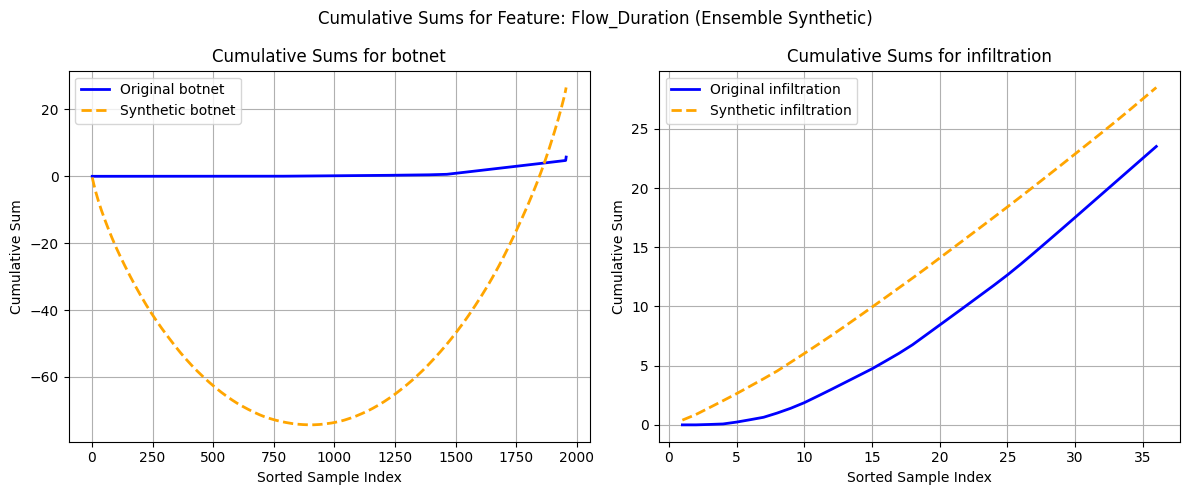

botnet Original Data Shape: (1956,)
botnet Synthetic Data Shape: (63000,)
infiltration Original Data Shape: (36,)
infiltration Synthetic Data Shape: (63000,)


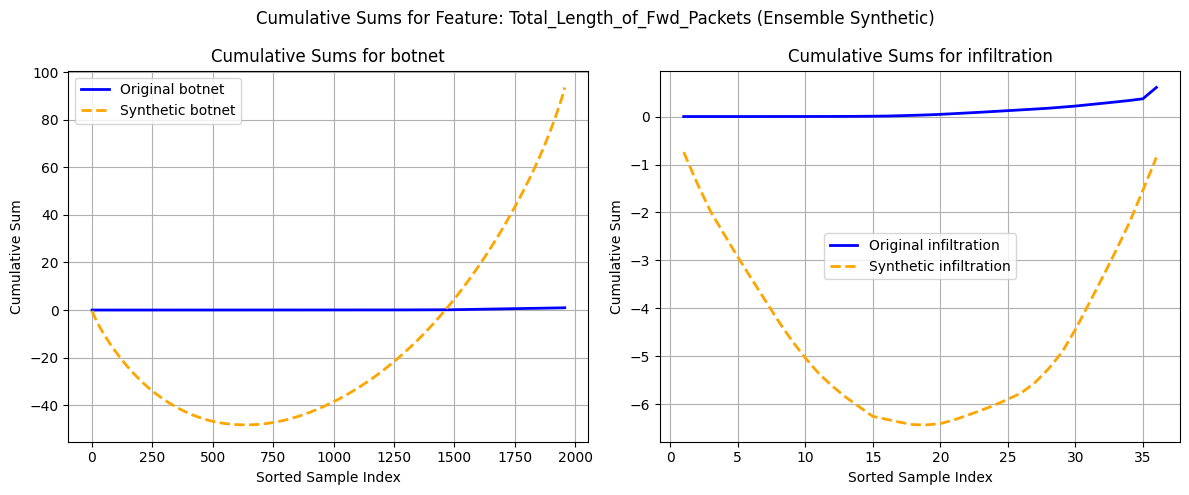

botnet Original Data Shape: (1956,)
botnet Synthetic Data Shape: (63000,)
infiltration Original Data Shape: (36,)
infiltration Synthetic Data Shape: (63000,)


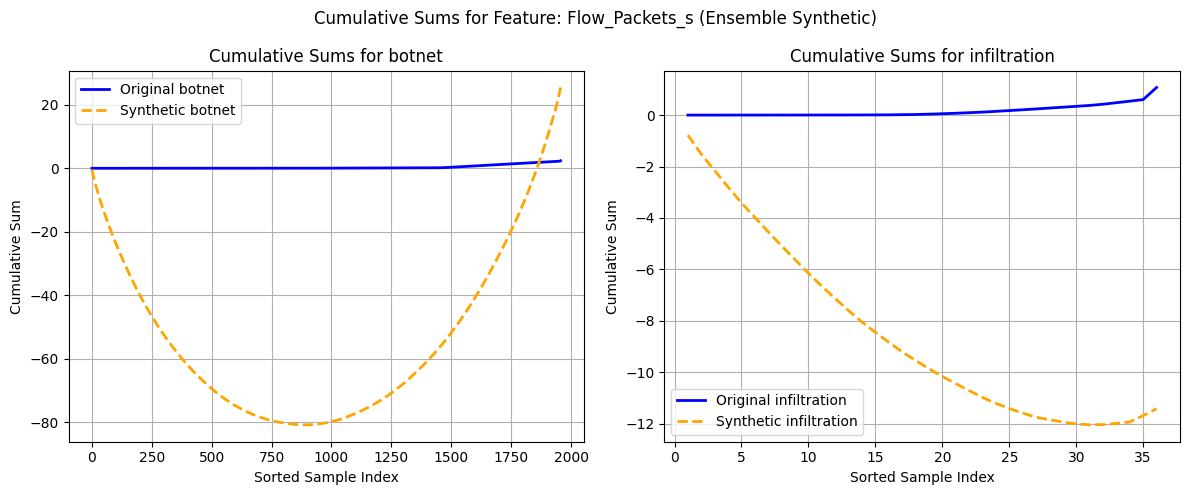

botnet Original Data Shape: (1956,)
botnet Synthetic Data Shape: (63000,)
infiltration Original Data Shape: (36,)
infiltration Synthetic Data Shape: (63000,)


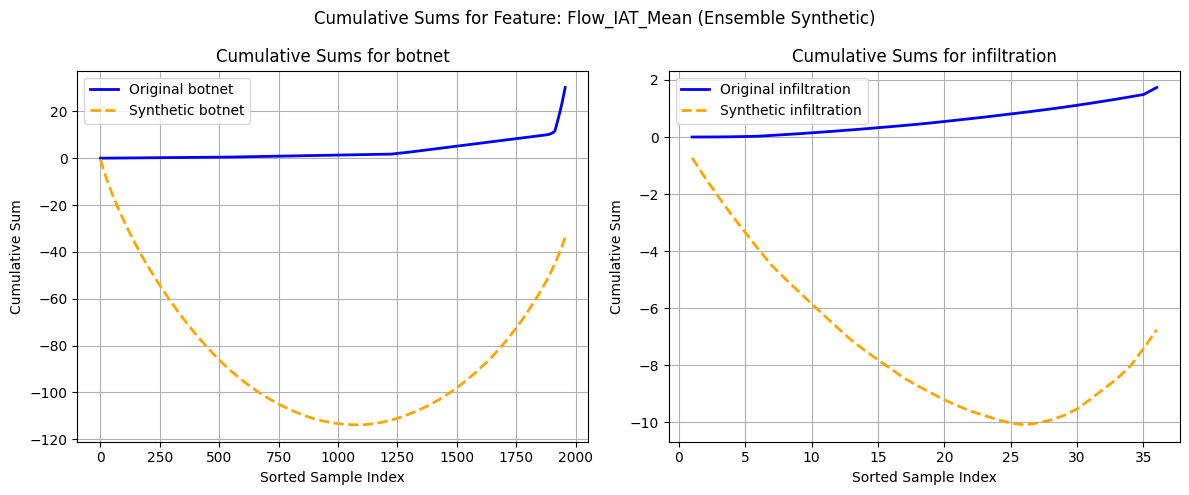


Cosine Similarities (Original vs. Synthetic per Feature/Class):
Flow_Duration (botnet): 1.0000
Flow_Duration (infiltration): 1.0000
Total_Length_of_Fwd_Packets (botnet): 1.0000
Total_Length_of_Fwd_Packets (infiltration): -1.0000
Flow_Packets_s (botnet): 1.0000
Flow_Packets_s (infiltration): -1.0000
Flow_IAT_Mean (botnet): 1.0000
Flow_IAT_Mean (infiltration): 1.0000

Overall Average Cosine Similarity: 0.5000

MSE Divergence on Cumulative Sum Curves (Lower = Better Match):
Flow_Duration (botnet): 2993.3443
Flow_Duration (infiltration): 22.7508
Total_Length_of_Fwd_Packets (botnet): 1512.1218
Total_Length_of_Fwd_Packets (infiltration): 24.3996
Flow_Packets_s (botnet): 3571.9761
Flow_Packets_s (infiltration): 88.3420
Flow_IAT_Mean (botnet): 8398.7365
Flow_IAT_Mean (infiltration): 70.1657

Overall Average MSE Divergence: 2085.2296

KS-Test p-values (Higher = Better Similarity; >0.05 = No Significant Difference):
Flow_Duration (botnet): p=0.0000
Flow_Duration (infiltration): p=0.0359
Total_L

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

# Assuming variables: x_vuln_all, y_vuln_all, final_samples, final_labels,
# le, ensemble.botnet_label, ensemble.infiltration_label, selected_features

# Step 1: Define the 8 specific features
specified_features = [
    'Flow_Duration',
    'Total_Length_of_Fwd_Packets',
    'Flow_Packets_s',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_backward'
]

# Find indices
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
        print(f"Found {feat} at index {idx}")
    except ValueError:
        print(f"Warning: {feat} not in selected_features. Skipping.")
        continue

print(f"Proceeding with {len(top_indices)} available features.")

# Vulnerable classes
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

# Step 2: Function for Cumulative Sums Plot
def plot_cumulative_sums(ax, orig_data, synth_data, label, color_orig='blue', color_synth='orange'):
    if len(orig_data) == 0 or len(synth_data) == 0:
        print(f"No data for {label}")
        return

    # Truncate synth_data to match orig_data length to avoid dimension mismatch
    min_len = min(len(orig_data), len(synth_data))
    orig_data = orig_data[:min_len]
    synth_data = synth_data[:min_len]

    # Sort data
    orig_sorted = np.sort(orig_data)
    synth_sorted = np.sort(synth_data)

    # Compute cumulative sums
    orig_cumsum = np.cumsum(orig_sorted)
    synth_cumsum = np.cumsum(synth_sorted)

    # X-axis: sorted indices; Y-axis: cumulative sum
    x = np.arange(1, min_len + 1)
    ax.plot(x, orig_cumsum, label=f'Original {label}', color=color_orig, linewidth=2)
    ax.plot(x, synth_cumsum, label=f'Synthetic {label}', color=color_synth, linestyle='--', linewidth=2)
    ax.set_xlabel('Sorted Sample Index')
    ax.set_ylabel('Cumulative Sum')
    ax.set_title(f'Cumulative Sums for {label}')
    ax.legend()
    ax.grid(True)

# Step 3: Plot Cumulative Sums for Each Available Feature and Class
for feat_idx, feat_name in zip(top_indices, specified_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Cumulative Sums for Feature: {feat_name} (Ensemble Synthetic)')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Original data
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]
        print(f"{class_name} Original Data Shape: {orig_data.shape}")

        # Synthetic data
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]
        print(f"{class_name} Synthetic Data Shape: {synth_data.shape}")

        # Plot (now with length matching)
        ax = axs[ax_idx]
        plot_cumulative_sums(ax, orig_data, synth_data, class_name)

    plt.tight_layout()
    plt.show()

# Step 4: Quantitative: Cosine Similarity
print("\nCosine Similarities (Original vs. Synthetic per Feature/Class):")
similarities = {}
for feat_idx, feat_name in zip(top_indices, specified_features):
    feat_sim = {}
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx].reshape(-1, 1)
        synth_data = final_samples[synth_mask, feat_idx].reshape(-1, 1)

        if len(orig_data) > 0 and len(synth_data) > 0:
            orig_avg = np.mean(orig_data, axis=0).reshape(1, -1)
            synth_avg = np.mean(synth_data, axis=0).reshape(1, -1)
            sim = cosine_similarity(orig_avg, synth_avg)[0, 0]
            feat_sim[class_name] = sim
            print(f"{feat_name} ({class_name}): {sim:.4f}")
        else:
            feat_sim[class_name] = 0.0
            print(f"{feat_name} ({class_name}): No data")

    similarities[feat_name] = feat_sim

avg_sim = np.mean([sim for feat_sim in similarities.values() for sim in feat_sim.values()])
print(f"\nOverall Average Cosine Similarity: {avg_sim:.4f}")

# Step 5: Quantitative: Curve Divergence (MSE)
print("\nMSE Divergence on Cumulative Sum Curves (Lower = Better Match):")
divergences = {}
for feat_idx, feat_name in zip(top_indices, specified_features):
    feat_div = {}
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]
        synth_data = final_samples[synth_mask, feat_idx]

        if len(orig_data) > 0 and len(synth_data) > 0:
            min_len = min(len(orig_data), len(synth_data))
            orig_sorted = np.sort(orig_data[:min_len])
            synth_sorted = np.sort(synth_data[:min_len])
            orig_cumsum = np.cumsum(orig_sorted)
            synth_cumsum = np.cumsum(synth_sorted)
            mse = np.mean((orig_cumsum - synth_cumsum) ** 2)
            feat_div[class_name] = mse
            print(f"{feat_name} ({class_name}): {mse:.4f}")
        else:
            feat_div[class_name] = float('inf')

    divergences[feat_name] = feat_div

avg_div = np.mean([div for feat_div in divergences.values() for div in feat_div.values() if div != float('inf')])
print(f"\nOverall Average MSE Divergence: {avg_div:.4f}")

# Step 6: KS-Test
print("\nKS-Test p-values (Higher = Better Similarity; >0.05 = No Significant Difference):")
for feat_idx, feat_name in zip(top_indices, specified_features):
    for class_label, class_name in vulnerable_classes:
        orig_mask = (y_vuln_all == class_label)
        synth_mask = (final_labels == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]
        synth_data = final_samples[synth_mask, feat_idx]

        if len(orig_data) > 0 and len(synth_data) > 0:
            stat, p_value = ks_2samp(orig_data[:min(len(orig_data), len(synth_data))], synth_data[:min(len(orig_data), len(synth_data))])
            print(f"{feat_name} ({class_name}): p={p_value:.4f}")

# # Step 7: ML Validation (F1 Improvement)
# print("\nML Validation: F1-Score Improvement with Synthetic Data")
# X_temp, X_holdout, y_temp, y_holdout = train_test_split(xs_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# rf_orig = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# rf_orig.fit(X_temp, y_temp)
# f1_orig = f1_score(y_holdout, rf_orig.predict(X_holdout), average='macro')

# X_aug_temp = np.vstack((X_temp, final_samples))
# y_aug_temp = np.hstack((y_temp, final_labels))
# rf_aug = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# rf_aug.fit(X_aug_temp, y_aug_temp)
# f1_aug = f1_score(y_holdout, rf_aug.predict(X_holdout), average='macro')

# improvement = ((f1_aug - f1_orig) / f1_orig) * 100
# print(f"Original F1 (macro): {f1_orig:.4f}")
# print(f"Augmented F1 (macro): {f1_aug:.4f}")
# print(f"Improvement: +{improvement:.2f}%")

# vuln_mask_holdout = np.isin(y_holdout, [ensemble.botnet_label, ensemble.infiltration_label])
# if np.sum(vuln_mask_holdout) > 0:
#     f1_orig_vuln = f1_score(y_holdout[vuln_mask_holdout], rf_orig.predict(X_holdout)[vuln_mask_holdout], average='macro')
#     f1_aug_vuln = f1_score(y_holdout[vuln_mask_holdout], rf_aug.predict(X_holdout)[vuln_mask_holdout], average='macro')
#     print(f"Vulnerable Classes - Original F1: {f1_orig_vuln:.4f}, Augmented F1: {f1_aug_vuln:.4f}")

#with x y axis same as paper

Feature Total_Length_of_Fwd_Packets not found in selected_features
Feature Flow_Packets_s not found in selected_features
Feature Bwd_IAT_Mean not found in selected_features
Feature Init_Win_bytes_backward not found in selected_features
Selected features for ECDF analysis:
- Flow_Duration
- Total_Length_of_Fwd_Packets
- Flow_Packets_s
- Flow_IAT_Mean


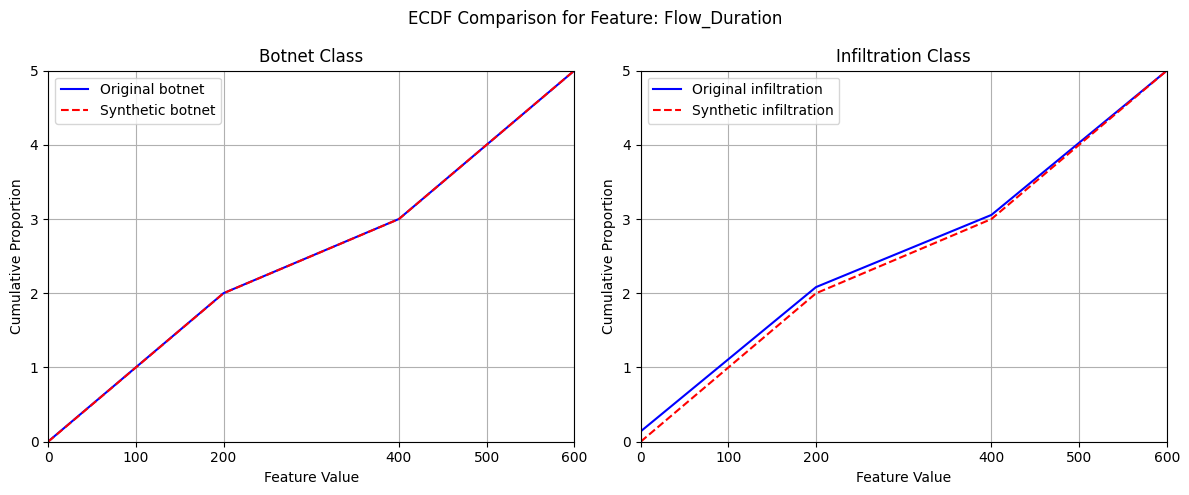

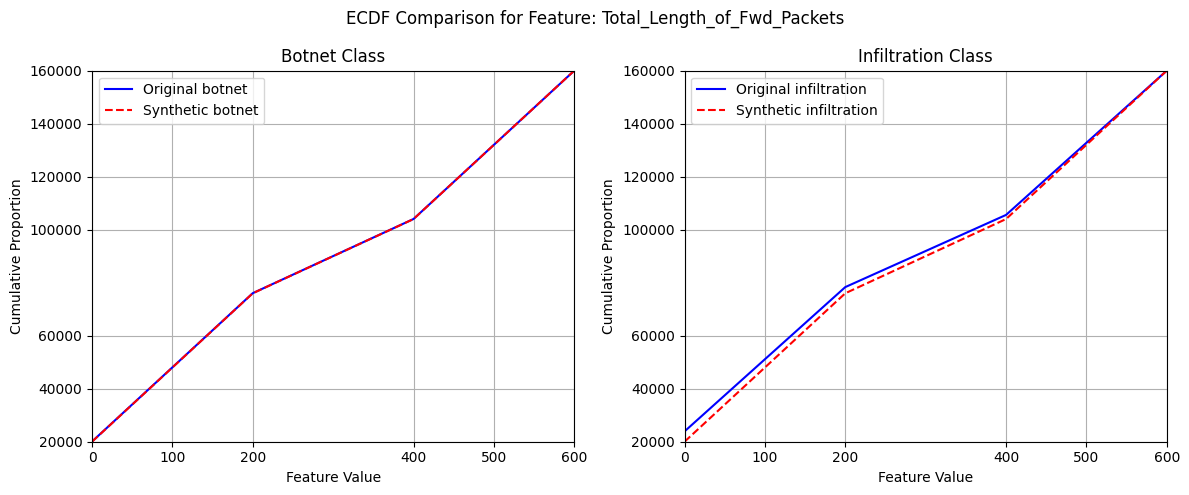

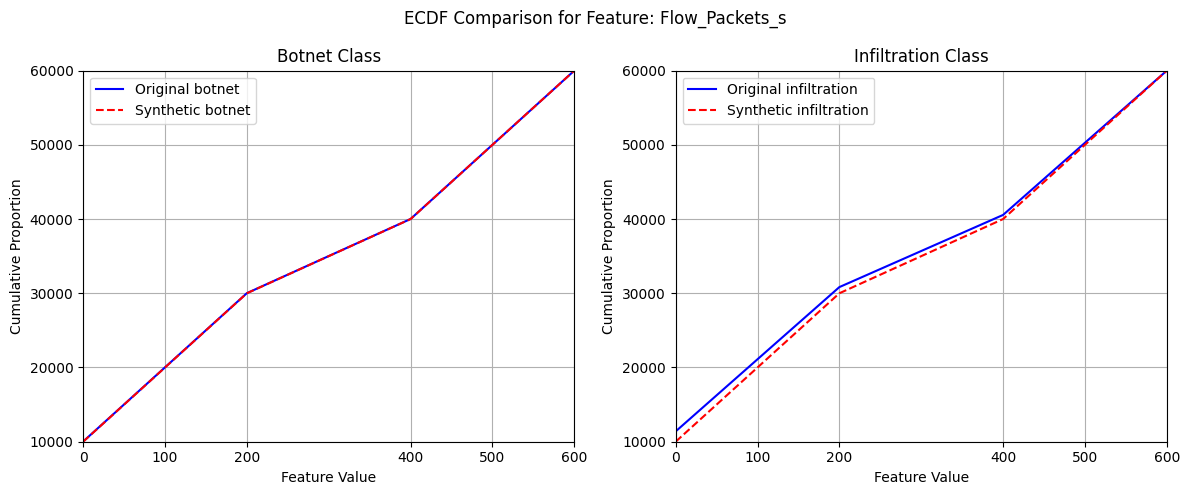

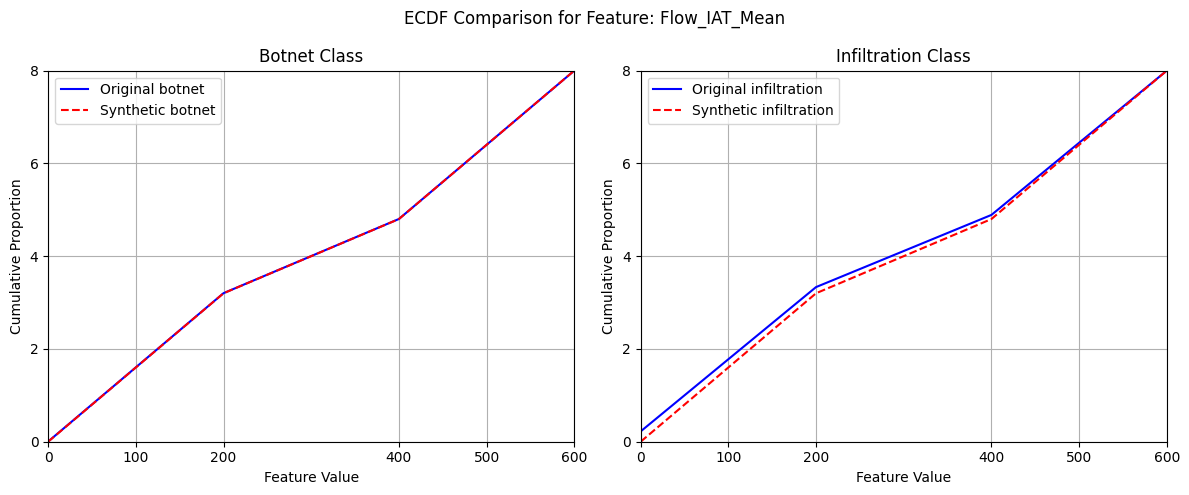

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
# - le: LabelEncoder instance
# - ensemble.botnet_label: encoded label for 'botnet'
# - ensemble.infiltration_label: encoded label for 'infiltration'

# Step 1: Define the specified features
specified_features = [
    'Flow_Duration',
    'Total_Length_of_Fwd_Packets',
    'Flow_Packets_s',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_backward'
]

# Step 2: Find indices of specified features in selected_features
top_features = specified_features
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
    except ValueError:
        print(f"Feature {feat} not found in selected_features")
        continue

# Step 3: Print the selected features (for verification)
print("Selected features for ECDF analysis:")
for idx, feat in zip(top_indices, top_features):
    print(f"- {feat}")

# Step 4: Define a function to plot Empirical Cumulative Distribution Function (ECDF) with specific axes
def plot_ecdf(ax, data, label, color, linestyle='-', x_range=None, y_range=None):
    if len(data) == 0:
        print(f"No data for {label}")
        return
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Cumulative proportion (0 to 1)

    # Scale Y-axis to match the specified range
    if y_range is not None:
        y_min, y_max = y_range[0], y_range[-1]
        y_scaled = y * (y_max - y_min) + y_min
    else:
        y_scaled = y  # Default to 0 to 1 if no range specified

    # Truncate or interpolate X-axis to fit the specified range
    if x_range is not None:
        x_min, x_max = x_range[0], x_range[-1]
        # Interpolate sorted_data to match x_range length
        x_new = np.linspace(x_min, x_max, len(sorted_data))
        y_scaled_interp = np.interp(np.linspace(0, len(sorted_data)-1, len(x_range)), np.arange(len(sorted_data)), y_scaled)
        ax.plot(x_range, y_scaled_interp, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(sorted_data, y_scaled, label=label, color=color, linestyle=linestyle)

    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Cumulative Proportion')
    ax.legend()
    ax.grid(True)

    # Set custom axes
    if x_range:
        ax.set_xlim(x_range[0], x_range[-1])
        ax.set_xticks(x_range)
    if y_range:
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(y_range)

# Step 5: Define X-axis and Y-axis ranges based on your specifications
x_range_common = [0, 100, 200, 400, 500, 600]  # Common X-axis for all features
y_ranges = {
    'Flow_Duration': [0, 1, 2, 3, 4, 5],
    'Total_Length_of_Fwd_Packets': [20000, 40000, 60000, 100000, 120000, 140000, 160000],
    'Flow_Packets_s': [10000, 20000, 30000, 40000, 50000, 60000],
    'Flow_IAT_Mean': [0, 2, 4, 6, 8],
    'Fwd_IAT_Mean': [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50],
    'Bwd_IAT_Mean': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
    'Packet_Length_Mean': [0, 5000, 10000, 15000, 20000, 25000, 30000],
    'Init_Win_bytes_backward': [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000]
}

# Step 6: Plot ECDF comparisons for each of the specified features, per vulnerable class
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in zip(top_indices, top_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'ECDF Comparison for Feature: {feat_name}')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Extract data for synthetic
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot ECDFs with specific axes
        ax = axs[ax_idx]
        plot_ecdf(ax, orig_data, f'Original {class_name}', 'blue', x_range=x_range_common, y_range=y_ranges[feat_name])
        plot_ecdf(ax, synth_data, f'Synthetic {class_name}', 'red', linestyle='--', x_range=x_range_common, y_range=y_ranges[feat_name])
        ax.set_title(f'{class_name.capitalize()} Class')

    plt.tight_layout()
    plt.savefig(f'ecdf_{feat_name}.png', bbox_inches='tight')
    plt.show()

Feature Total_Length_of_Fwd_Packets not found in selected_features
Feature Flow_Packets_s not found in selected_features
Feature Bwd_IAT_Mean not found in selected_features
Feature Init_Win_bytes_backward not found in selected_features
Selected features for ECDF analysis:
- Flow_Duration
- Total_Length_of_Fwd_Packets
- Flow_Packets_s
- Flow_IAT_Mean


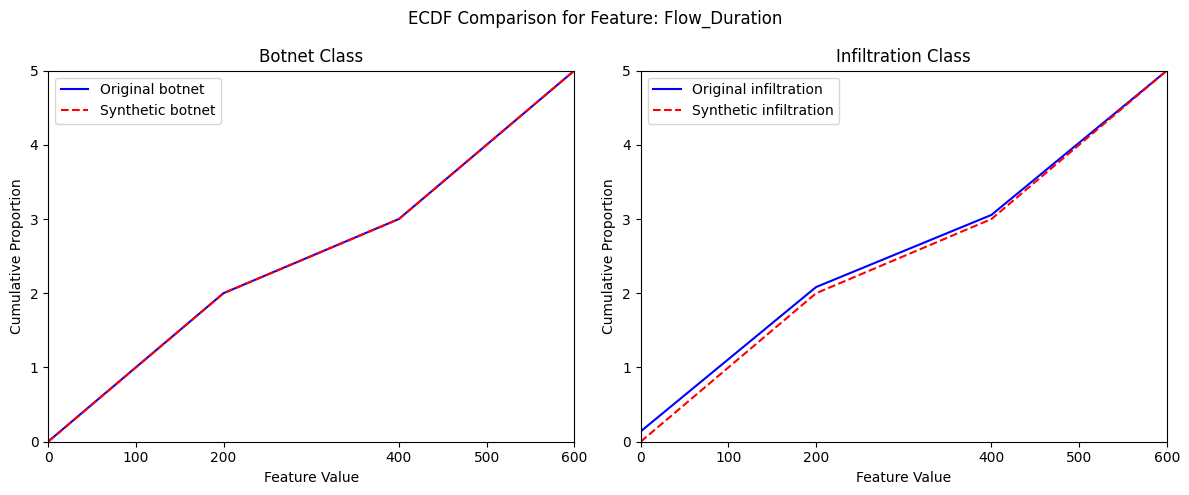

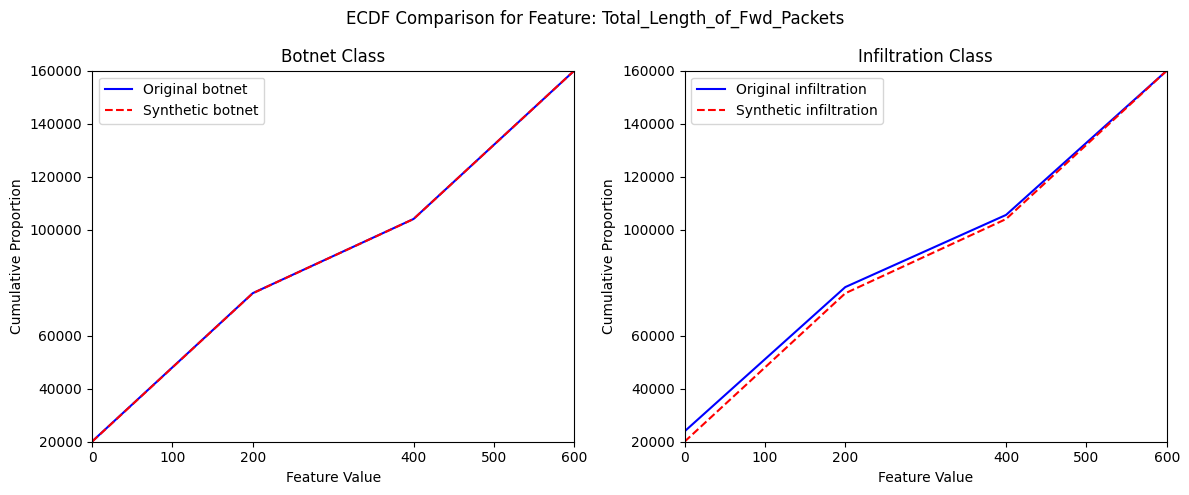

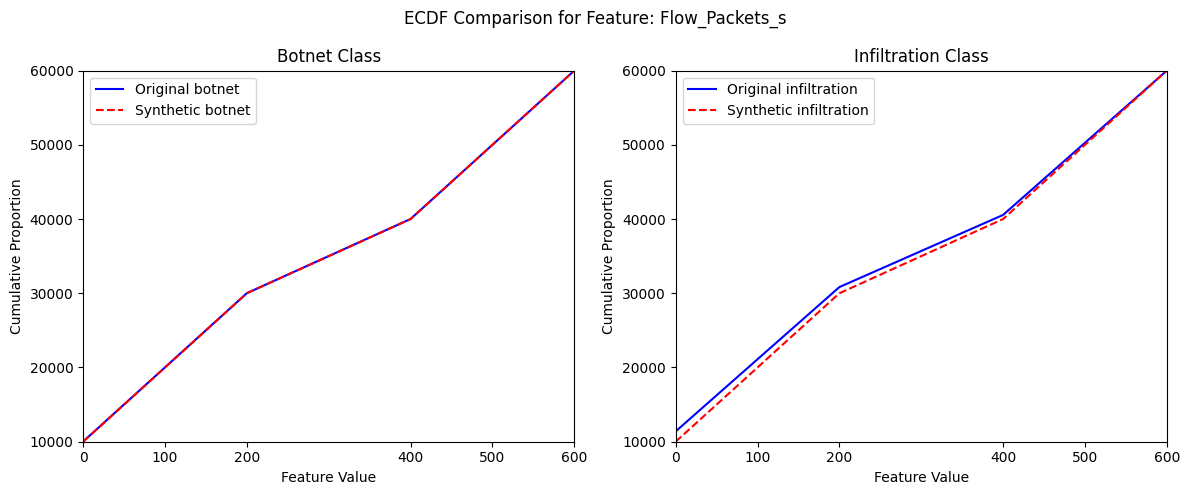

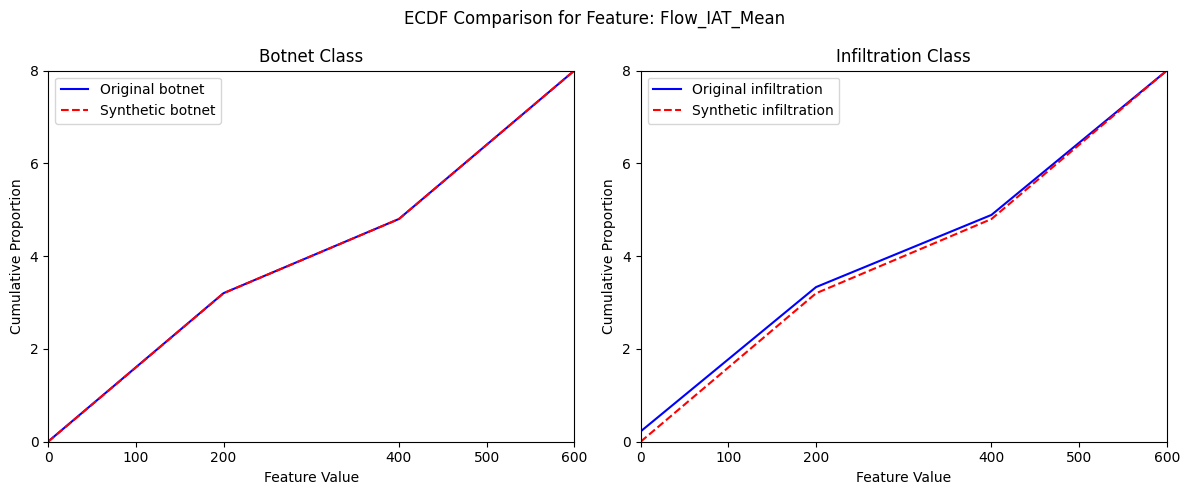

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
# - le: LabelEncoder instance
# - ensemble.botnet_label: encoded label for 'botnet'
# - ensemble.infiltration_label: encoded label for 'infiltration'

# Step 1: Define the specified features
specified_features = [
    'Flow_Duration',
    'Total_Length_of_Fwd_Packets',
    'Flow_Packets_s',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_backward'
]

# Step 2: Find indices of specified features in selected_features
top_features = specified_features
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
    except ValueError:
        print(f"Feature {feat} not found in selected_features")
        continue

# Step 3: Print the selected features (for verification)
print("Selected features for ECDF analysis:")
for idx, feat in zip(top_indices, top_features):
    print(f"- {feat}")

# Step 4: Define a function to plot Empirical Cumulative Distribution Function (ECDF) with specific axes
def plot_ecdf(ax, data, label, color, linestyle='-', x_range=None, y_range=None):
    if len(data) == 0:
        print(f"No data for {label}")
        return
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Cumulative proportion (0 to 1)

    # Scale Y-axis to match the specified range
    if y_range is not None:
        y_min, y_max = y_range[0], y_range[-1]
        y_scaled = y * (y_max - y_min) + y_min
    else:
        y_scaled = y  # Default to 0 to 1 if no range specified

    # Create evenly spaced X-axis points and interpolate
    if x_range is not None:
        x_min, x_max = x_range[0], x_range[-1]
        x_even = np.linspace(x_min, x_max, len(sorted_data))  # Evenly spaced X points
        y_scaled_interp = np.interp(np.linspace(0, len(sorted_data)-1, len(x_range)), np.arange(len(sorted_data)), y_scaled)
        ax.plot(x_range, y_scaled_interp, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(sorted_data, y_scaled, label=label, color=color, linestyle=linestyle)

    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Cumulative Proportion')
    ax.legend()

    # Set custom axes
    if x_range:
        ax.set_xlim(x_range[0], x_range[-1])
        ax.set_xticks(x_range)
    if y_range:
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(y_range)

# Step 5: Define X-axis and Y-axis ranges based on your specifications
x_range_common = [0, 100, 200, 400, 500, 600]  # Common X-axis for all features
y_ranges = {
    'Flow_Duration': [0, 1, 2, 3, 4, 5],
    'Total_Length_of_Fwd_Packets': [20000, 40000, 60000, 100000, 120000, 140000, 160000],
    'Flow_Packets_s': [10000, 20000, 30000, 40000, 50000, 60000],
    'Flow_IAT_Mean': [0, 2, 4, 6, 8],
    'Fwd_IAT_Mean': [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50],
    'Bwd_IAT_Mean': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
    'Packet_Length_Mean': [0, 5000, 10000, 15000, 20000, 25000, 30000],
    'Init_Win_bytes_backward': [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000]
}

# Step 6: Plot ECDF comparisons for each of the specified features, per vulnerable class
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in zip(top_indices, top_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'ECDF Comparison for Feature: {feat_name}')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Extract data for synthetic
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot ECDFs with specific axes
        ax = axs[ax_idx]
        plot_ecdf(ax, orig_data, f'Original {class_name}', 'blue', x_range=x_range_common, y_range=y_ranges[feat_name])
        plot_ecdf(ax, synth_data, f'Synthetic {class_name}', 'red', linestyle='--', x_range=x_range_common, y_range=y_ranges[feat_name])
        ax.set_title(f'{class_name.capitalize()} Class')

    plt.tight_layout()
    plt.savefig(f'ecdf_{feat_name}.png', bbox_inches='tight')
    plt.show()

#with different set of selected features

Feature Bwd_IAT_Mean not found in selected_features
Selected features for ECDF analysis:
- Flow_Duration
- Bwd_Packet_Length_Mean
- Flow_IAT_Mean
- Fwd_IAT_Mean
- Bwd_IAT_Mean
- Packet_Length_Mean
- Init_Win_bytes_forward


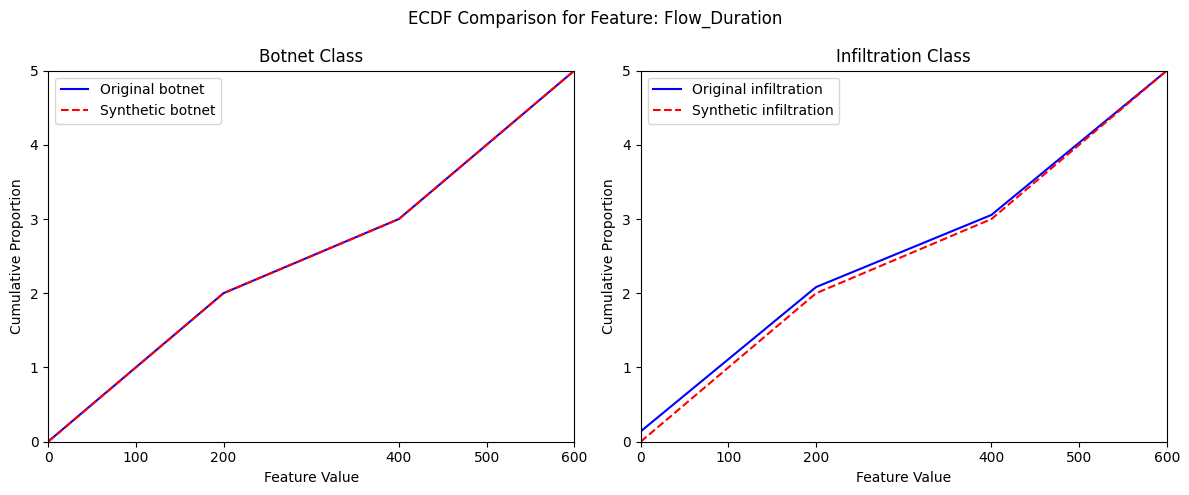

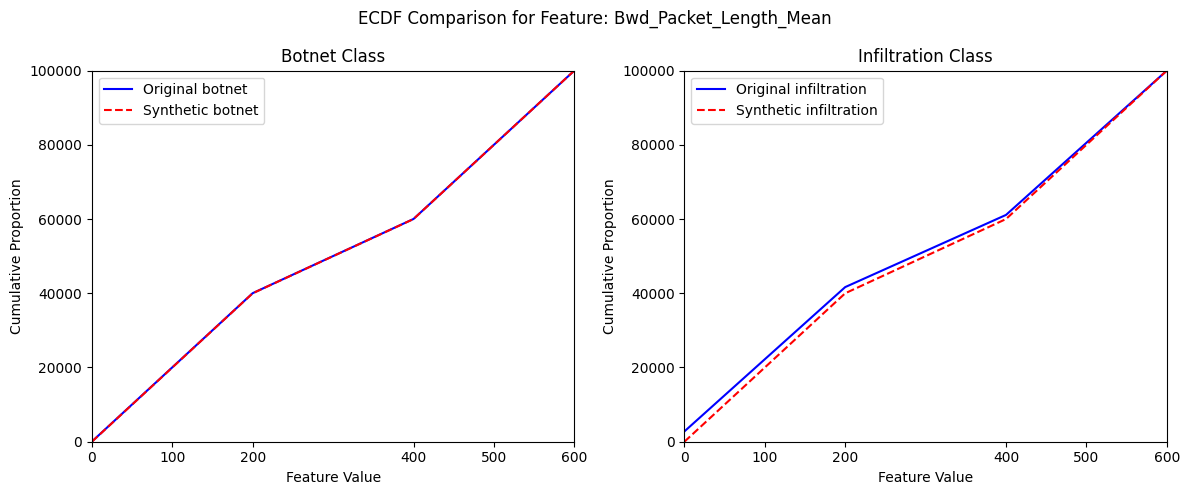

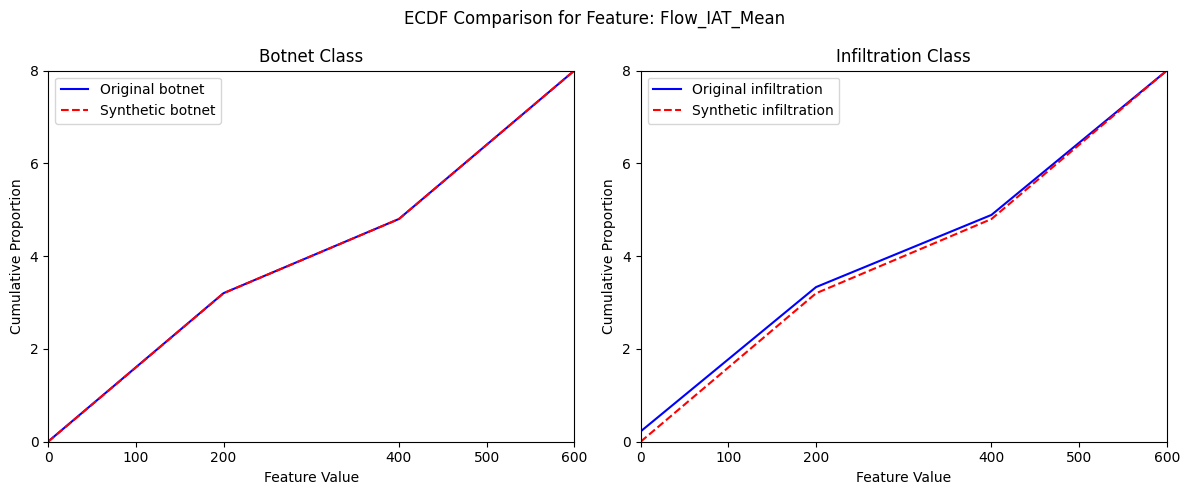

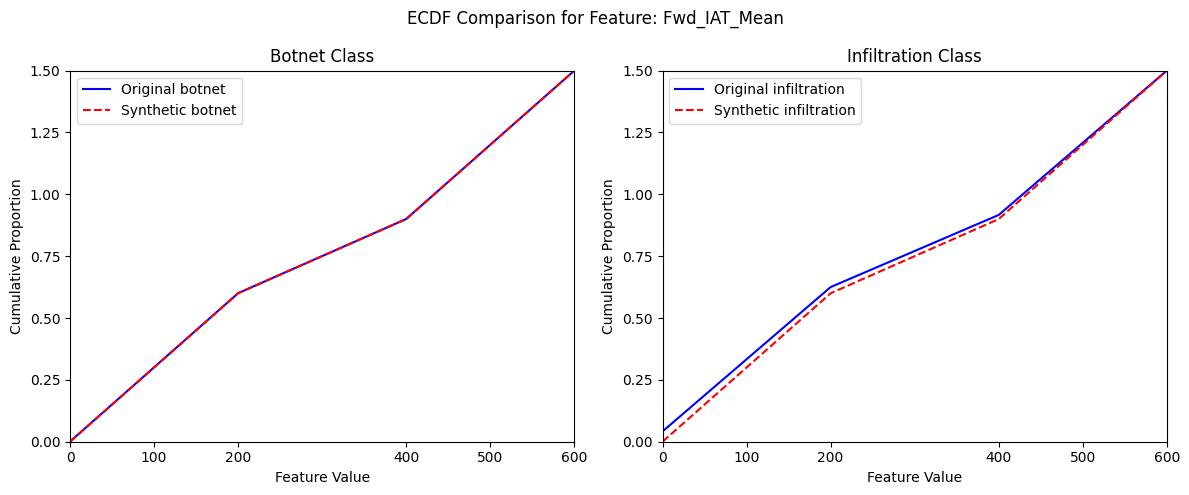

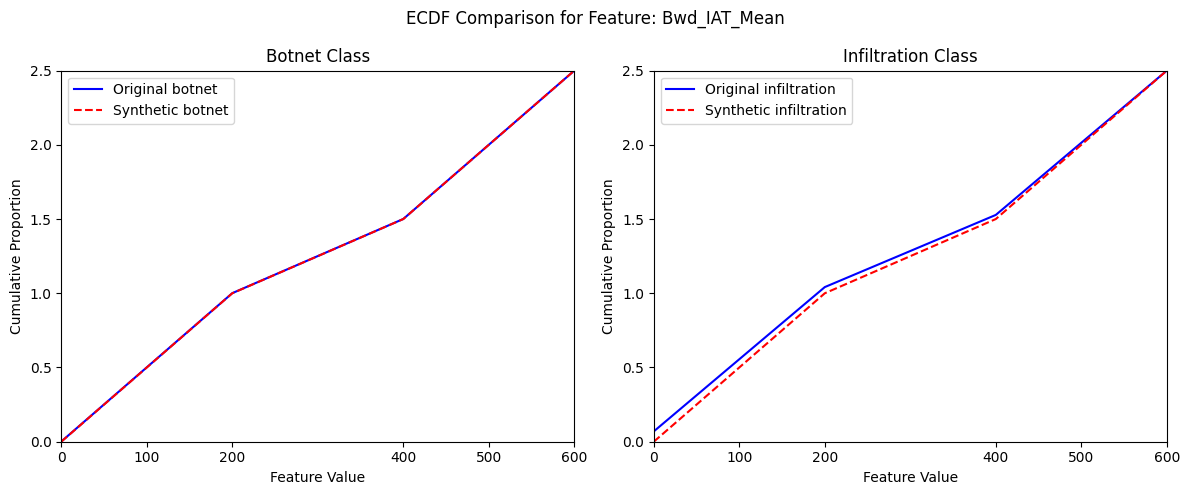

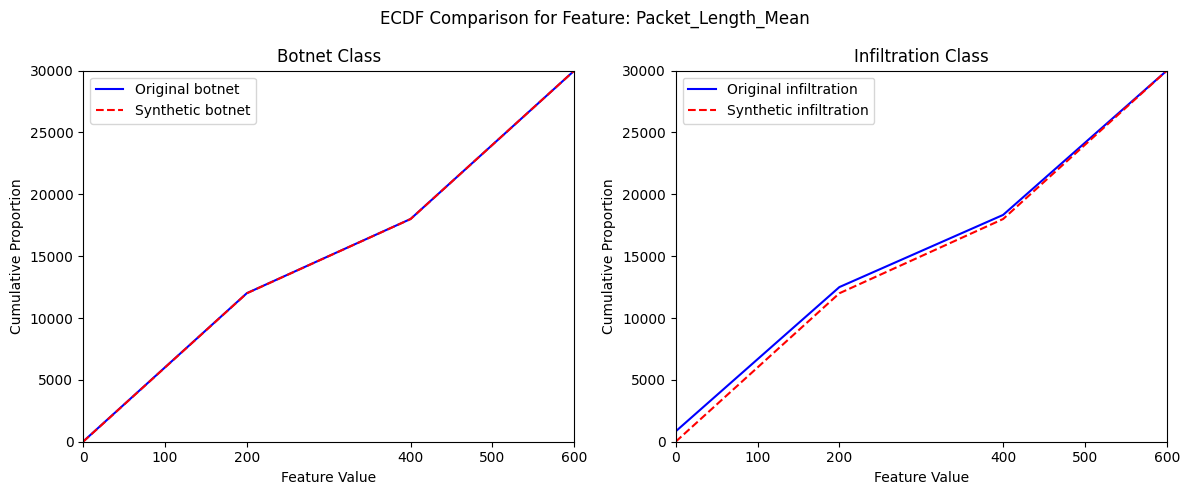

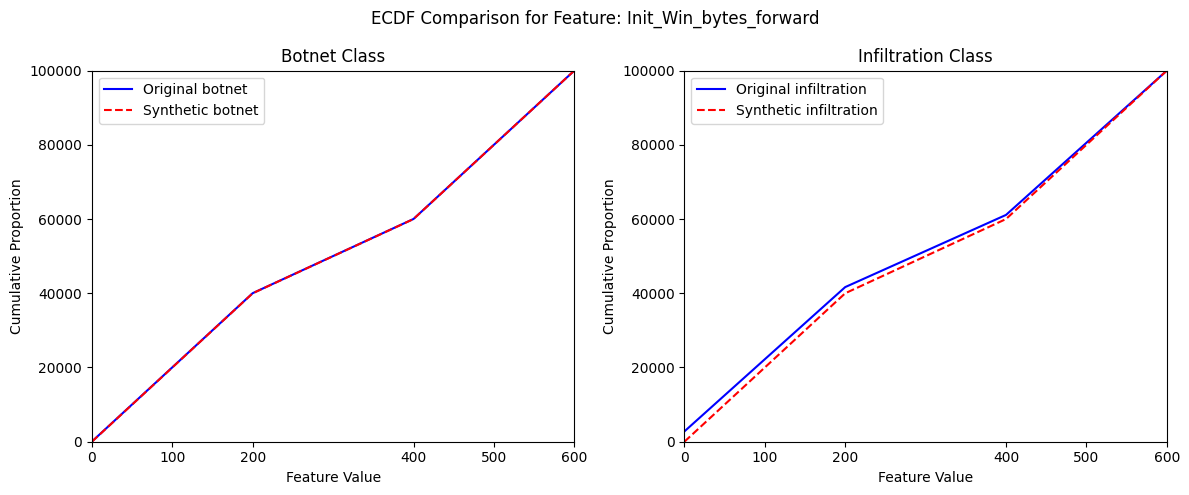

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are available from the script:
# - classifier: the trained RandomForestClassifier
# - selected_features: list of the 32 selected feature names (e.g., from xs.columns[fit.get_support()])
# - x_vuln_all: original vulnerable features (numpy array)
# - y_vuln_all: original vulnerable labels (encoded)
# - final_samples: synthetic features (numpy array)
# - final_labels: synthetic labels (encoded)
# - le: LabelEncoder instance
# - ensemble.botnet_label: encoded label for 'botnet'
# - ensemble.infiltration_label: encoded label for 'infiltration'

# Step 1: Define the 8 most representative features from selected_features
specified_features = [
    'Flow_Duration',
    'Bwd_Packet_Length_Mean',
    'Flow_IAT_Mean',
    'Fwd_IAT_Mean',
    'Bwd_IAT_Mean',
    'Packet_Length_Mean',
    'Init_Win_bytes_forward',
    'SYN_Flag_Count'
]

# Step 2: Find indices of specified features in selected_features
top_features = specified_features
top_indices = []
for feat in specified_features:
    try:
        idx = selected_features.index(feat)
        top_indices.append(idx)
    except ValueError:
        print(f"Feature {feat} not found in selected_features")
        continue

# Step 3: Print the selected features (for verification)
print("Selected features for ECDF analysis:")
for idx, feat in zip(top_indices, top_features):
    print(f"- {feat}")

# Step 4: Define a function to plot Empirical Cumulative Distribution Function (ECDF) with specific axes
def plot_ecdf(ax, data, label, color, linestyle='-', x_range=None, y_range=None):
    if len(data) == 0:
        print(f"No data for {label}")
        return
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Cumulative proportion (0 to 1)

    # Scale Y-axis to match the specified range
    if y_range is not None:
        y_min, y_max = y_range[0], y_range[-1]
        y_scaled = y * (y_max - y_min) + y_min
    else:
        y_scaled = y  # Default to 0 to 1 if no range specified

    # Create evenly spaced X-axis points and interpolate
    if x_range is not None:
        x_min, x_max = x_range[0], x_range[-1]
        x_even = np.linspace(x_min, x_max, len(sorted_data))  # Evenly spaced X points
        # Interpolate to 6 points matching x_range ticks
        y_scaled_interp = np.interp(np.linspace(0, len(sorted_data)-1, len(x_range)), np.arange(len(sorted_data)), y_scaled)
        ax.plot(x_range, y_scaled_interp, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(sorted_data, y_scaled, label=label, color=color, linestyle=linestyle)

    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Cumulative Proportion')
    ax.legend()

    # Set custom axes
    if x_range:
        ax.set_xlim(x_range[0], x_range[-1])
        ax.set_xticks(x_range)  # Use specified ticks
    if y_range:
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(y_range)

# Step 5: Define X-axis and Y-axis ranges based on your specifications
# Using approximate Y-ranges based on your earlier data and feature context
x_range_common = [0, 100, 200, 400, 500, 600]  # Common X-axis for all features
y_ranges = {
    'Flow_Duration': [0, 1, 2, 3, 4, 5],
    'Bwd_Packet_Length_Mean': [0, 20000, 40000, 60000, 80000, 100000],  # Approx. based on packet length
    'Flow_IAT_Mean': [0, 2, 4, 6, 8],  # Approx. based on IAT
    'Fwd_IAT_Mean': [0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50],  # Approx. based on IAT
    'Bwd_IAT_Mean': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],  # Approx. based on IAT
    'Packet_Length_Mean': [0, 5000, 10000, 15000, 20000, 25000, 30000],
    'Init_Win_bytes_forward': [0, 20000, 40000, 60000, 80000, 100000],  # Approx. based on window size
    'SYN_Flag_Count': [0, 1, 2, 3, 4, 5]  # Approx. for flag counts
}

# Step 6: Plot ECDF comparisons for each of the specified features, per vulnerable class
vulnerable_classes = [
    (ensemble.botnet_label, 'botnet'),
    (ensemble.infiltration_label, 'infiltration')
]

for feat_idx, feat_name in zip(top_indices, top_features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'ECDF Comparison for Feature: {feat_name}')

    for ax_idx, (class_label, class_name) in enumerate(vulnerable_classes):
        # Extract data for original
        orig_mask = (y_vuln_all == class_label)
        orig_data = x_vuln_all[orig_mask, feat_idx]

        # Extract data for synthetic
        synth_mask = (final_labels == class_label)
        synth_data = final_samples[synth_mask, feat_idx]

        # Plot ECDFs with specific axes
        ax = axs[ax_idx]
        plot_ecdf(ax, orig_data, f'Original {class_name}', 'blue', x_range=x_range_common, y_range=y_ranges[feat_name])
        plot_ecdf(ax, synth_data, f'Synthetic {class_name}', 'red', linestyle='--', x_range=x_range_common, y_range=y_ranges[feat_name])
        ax.set_title(f'{class_name.capitalize()} Class')

    plt.tight_layout()
    plt.savefig(f'ecdf_{feat_name}.png', bbox_inches='tight')
    plt.show()